In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline
from ovejero import model_trainer, data_tools, bnn_inference

# Testing the Performance of Trained Models

__Author:__ Sebastian Wagner-Carena

__Created:__ 11/15/2019

__Last Run:__ 11/15/2019

__Goals:__ Inspect how the different bnn types and data augmentation strategies change the performance

## Diagonal Posterior - Normalizing Inputs

In [2]:
# First specify the config path
root_path = '/home/swagnercarena/ovejero/'
config_path = root_path + 'configs/nn1.json'

# Check that the config has what you need
cfg = model_trainer.load_config(config_path)

def recursive_str_checker(cfg_dict):
    for key in cfg_dict:
        if isinstance(cfg_dict[key],str):
            cfg_dict[key] = cfg_dict[key].replace('/home/swagnercarena/ovejero/',root_path)
        if isinstance(cfg_dict[key],dict):
            recursive_str_checker(cfg_dict[key])
recursive_str_checker(cfg)

# The InferenceClass will do all the heavy lifting of preparing the model from the configuration file,
# initializing the validation dataset, and providing outputs correctly marginalized over the BNN uncertainties.
bnn_infer = bnn_inference.InferenceClass(cfg)

# Now we just have to ask the InferenceClass to spin up some samples from our BNN. The more samples, the more
# accurate our plots and metrics will be. The right value to use unfortunately requires a bit of trial and error.
# 100 is a good starting point though.
num_samples = 1000
save_path_nn1 = root_path + 'validation_results/nn1_samps/'
bnn_infer.gen_samples(num_samples,save_path_nn1)

FileNotFoundError: [Errno 2] No such file or directory: '/home/swagnercarena/ovejero/configs/nn1.json'

In [56]:
bnn_infer.report_stats()

Parameter, RMSE, Median Abs Error, Median Std
external_shear_g1 0.03172164904014434 0.009179634158022438 0.013171962375363801
external_shear_g2 0.0234050858074675 0.009136209981117027 0.013462597475948062
lens_mass_center_x 0.014325606278097211 0.005098299197114301 0.010924836309030454
lens_mass_center_y 0.017250064376952447 0.005745650756056021 0.010860508298000794
lens_mass_e1 0.038900434459067754 0.01574557287493058 0.024780643200549228
lens_mass_e2 0.034081923249731895 0.014651851964889426 0.02495355817680672
lens_mass_gamma 0.062085898372364674 0.0341514786082161 0.04438594238123124
lens_mass_theta_E_log 0.019593227488260947 0.005581559274070669 0.009923934934643101


In [5]:
# num_lenses = 100
# bnn_infer.gen_coverage_plots(num_lenses=num_lenses)

In [6]:
# image_index = 8
# bnn_infer.plot_posterior_contours(image_index)

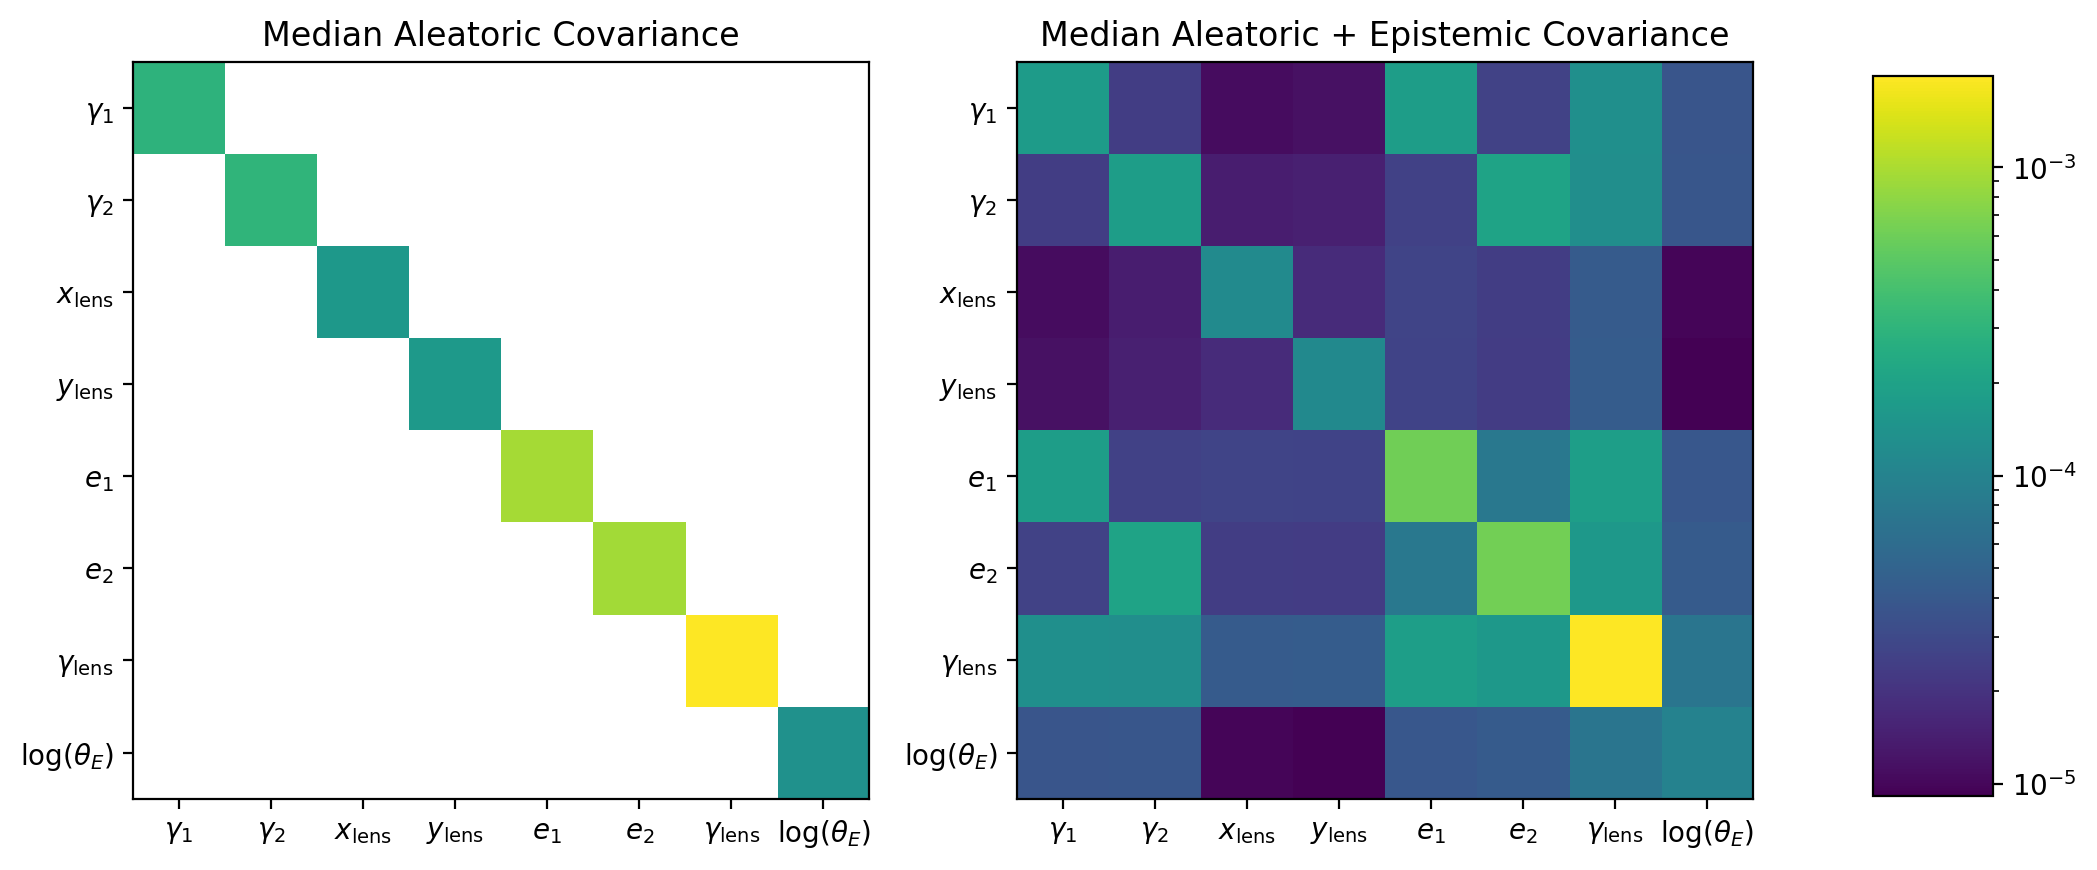

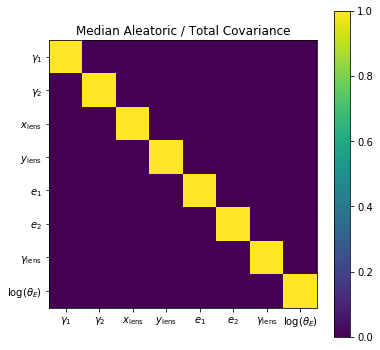

In [57]:
bnn_infer.comp_al_ep_unc(norm_diagonal=False)

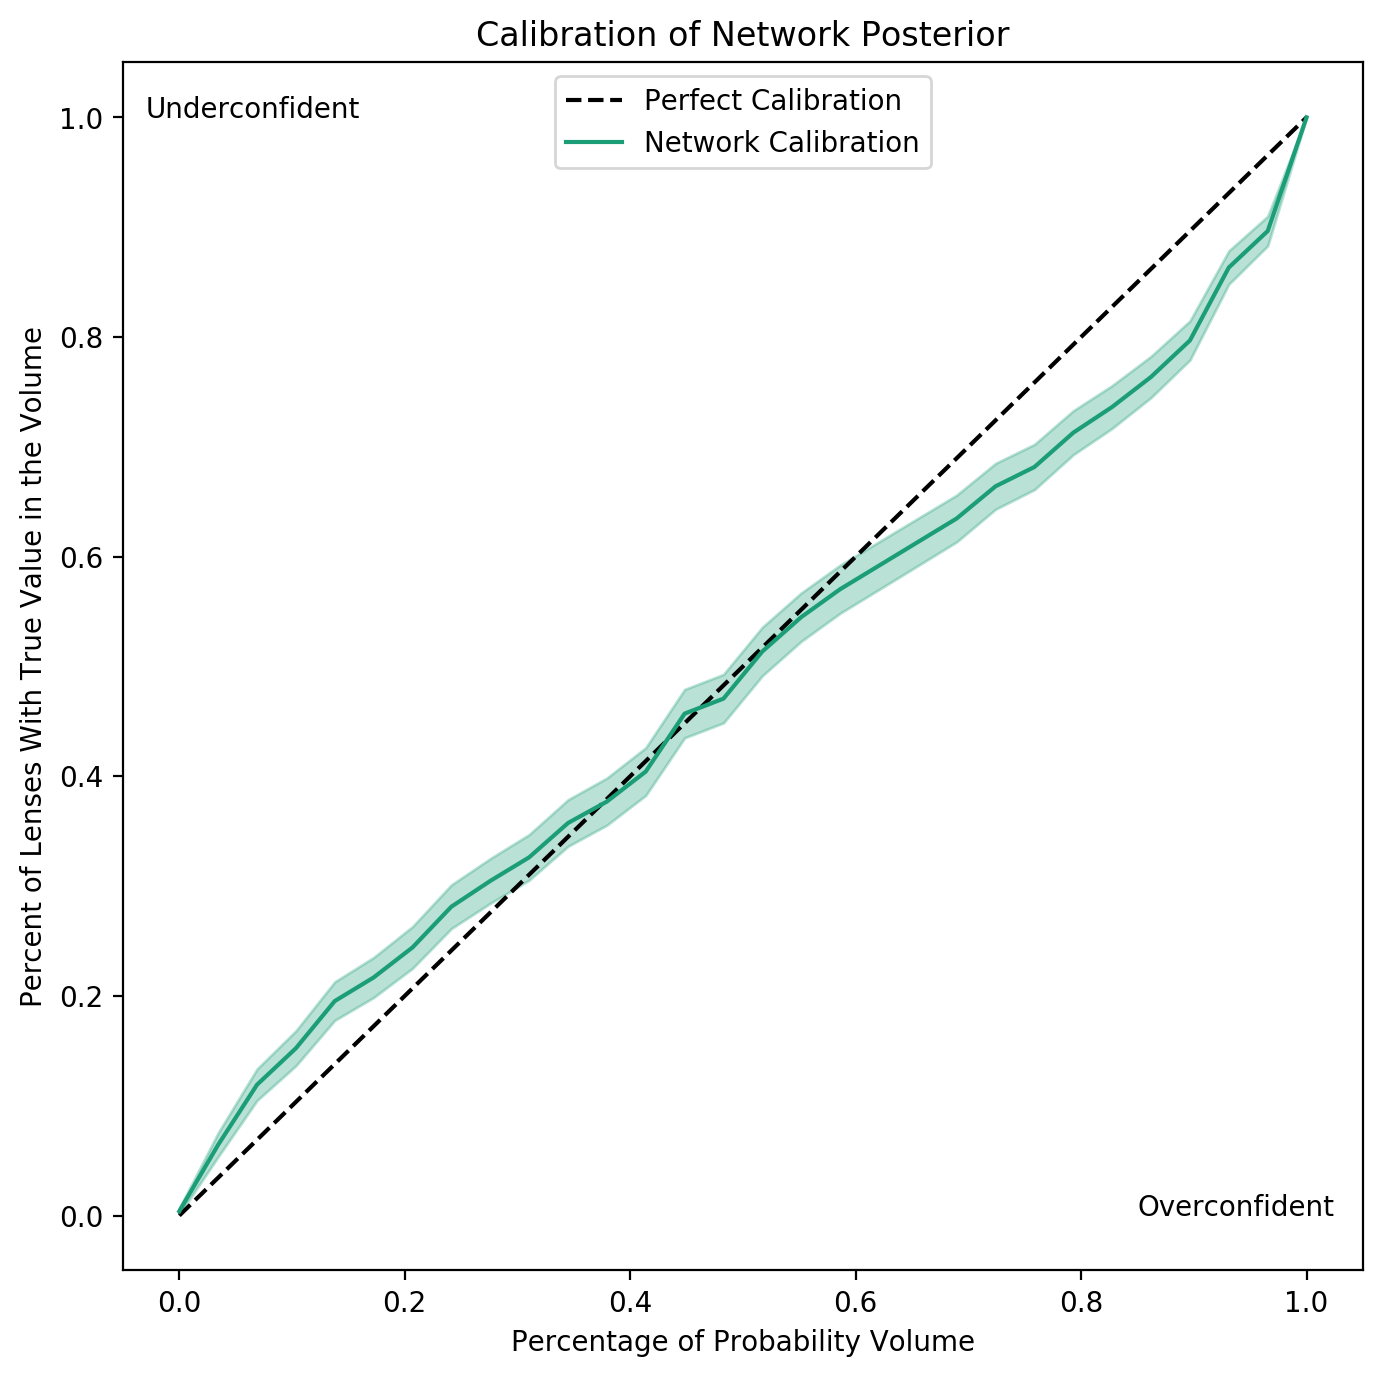

In [8]:
color_map = ['#000000','#1b9e77']
n_perc_points = 30
fig = bnn_infer.plot_calibration(color_map=color_map,n_perc_points=n_perc_points,show_plot=False)

## Diagonal High Regularizer

In [9]:
config_path = root_path + 'configs/nn1_hr.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)
bnn_infer = bnn_inference.InferenceClass(cfg)
save_path_nn1_hr = root_path + 'validation_results/nn1_hr_samps/'
bnn_infer.gen_samples(num_samples,save_path_nn1_hr)

Is model built: True
Loaded weights /home/swagnercarena/ovejero/models/nn1_hr.h5
Loading samples from /home/swagnercarena/ovejero/validation_results/nn1_hr_samps/


In [10]:
bnn_infer.report_stats()

Parameter, RMSE, Median Abs Error, Median Std
external_shear_g1 0.03765563266604856 0.012221469220572307 0.020297108832020492
external_shear_g2 0.027784553473519037 0.01251589620597081 0.021712972770142638
lens_mass_center_x 0.0165352104689946 0.006737624140088869 0.019261263967358926
lens_mass_center_y 0.01878621164674505 0.007300126625800613 0.019776829502305828
lens_mass_e1 0.04976078720672178 0.02122910817090229 0.04134723481138393
lens_mass_e2 0.04419157893817353 0.020580220590457318 0.042324508556098886
lens_mass_gamma 0.07693853978624289 0.03923077190113722 0.0731695435906444
lens_mass_theta_E_log 0.024105176256841273 0.00722832509958838 0.016297948404032453


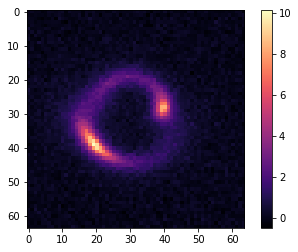

external_shear_g1 -0.054255422
external_shear_g2 0.058662377
lens_mass_center_x -0.070741676
lens_mass_center_y -0.08805807
lens_mass_e1 0.021547163
lens_mass_e2 0.12154392
lens_mass_gamma 2.2000444
lens_mass_theta_E_log -0.031269304


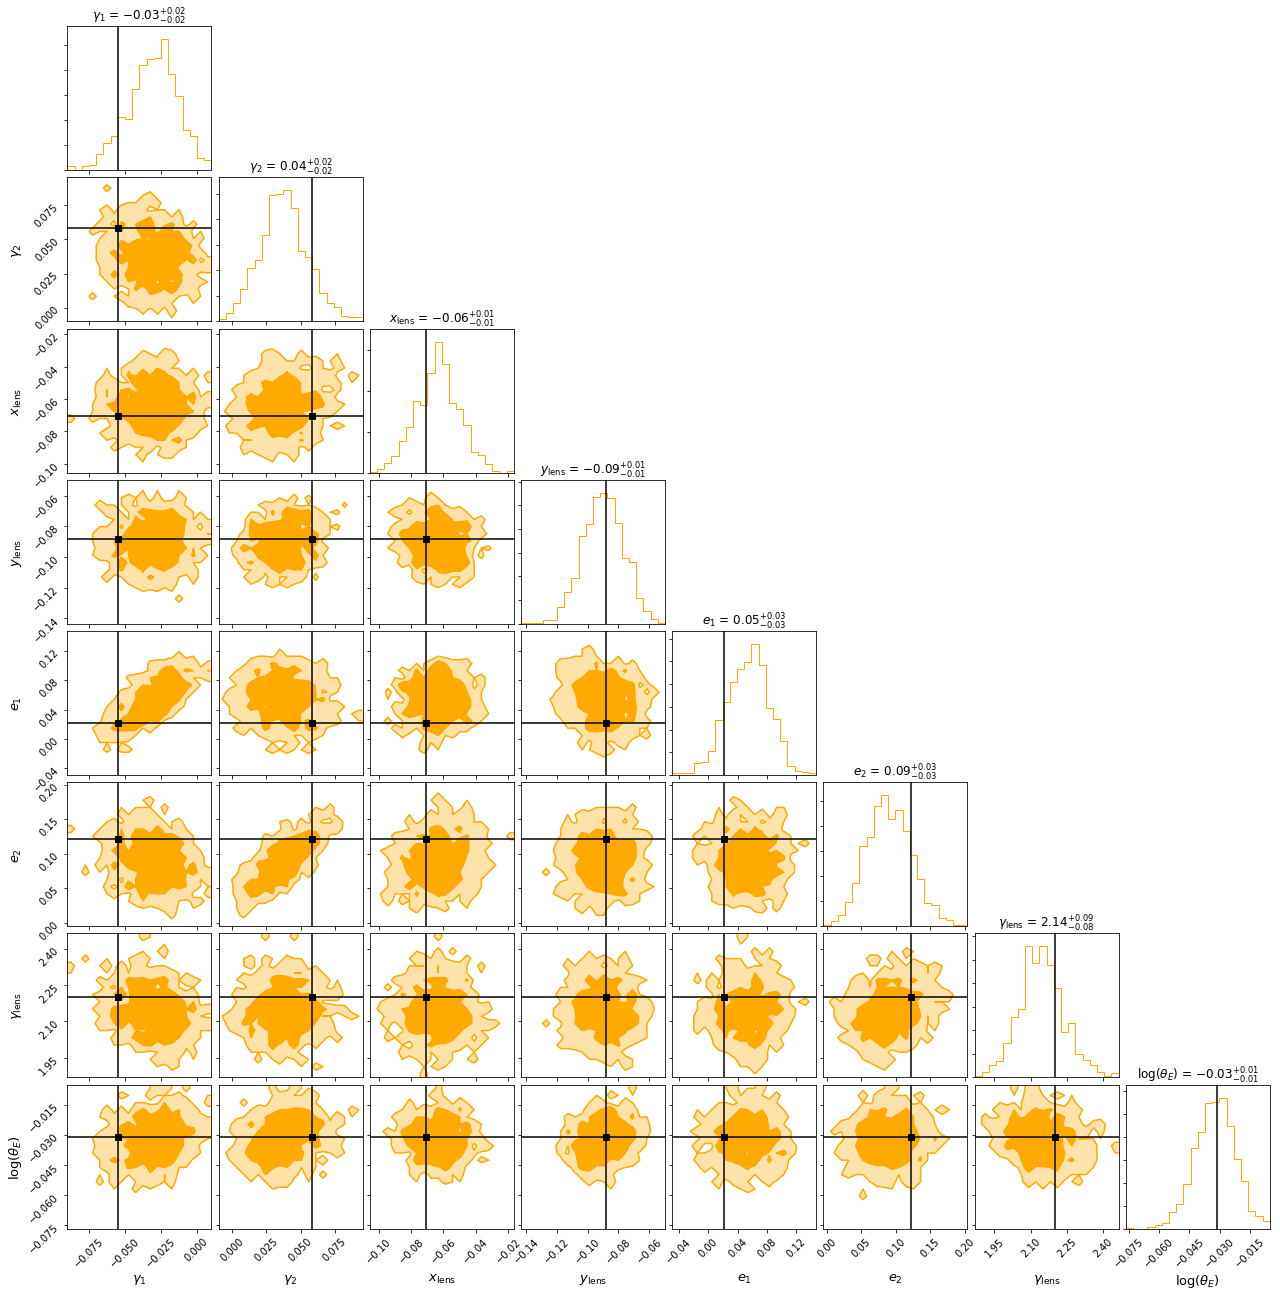

In [11]:
image_index = 8
bnn_infer.plot_posterior_contours(image_index)

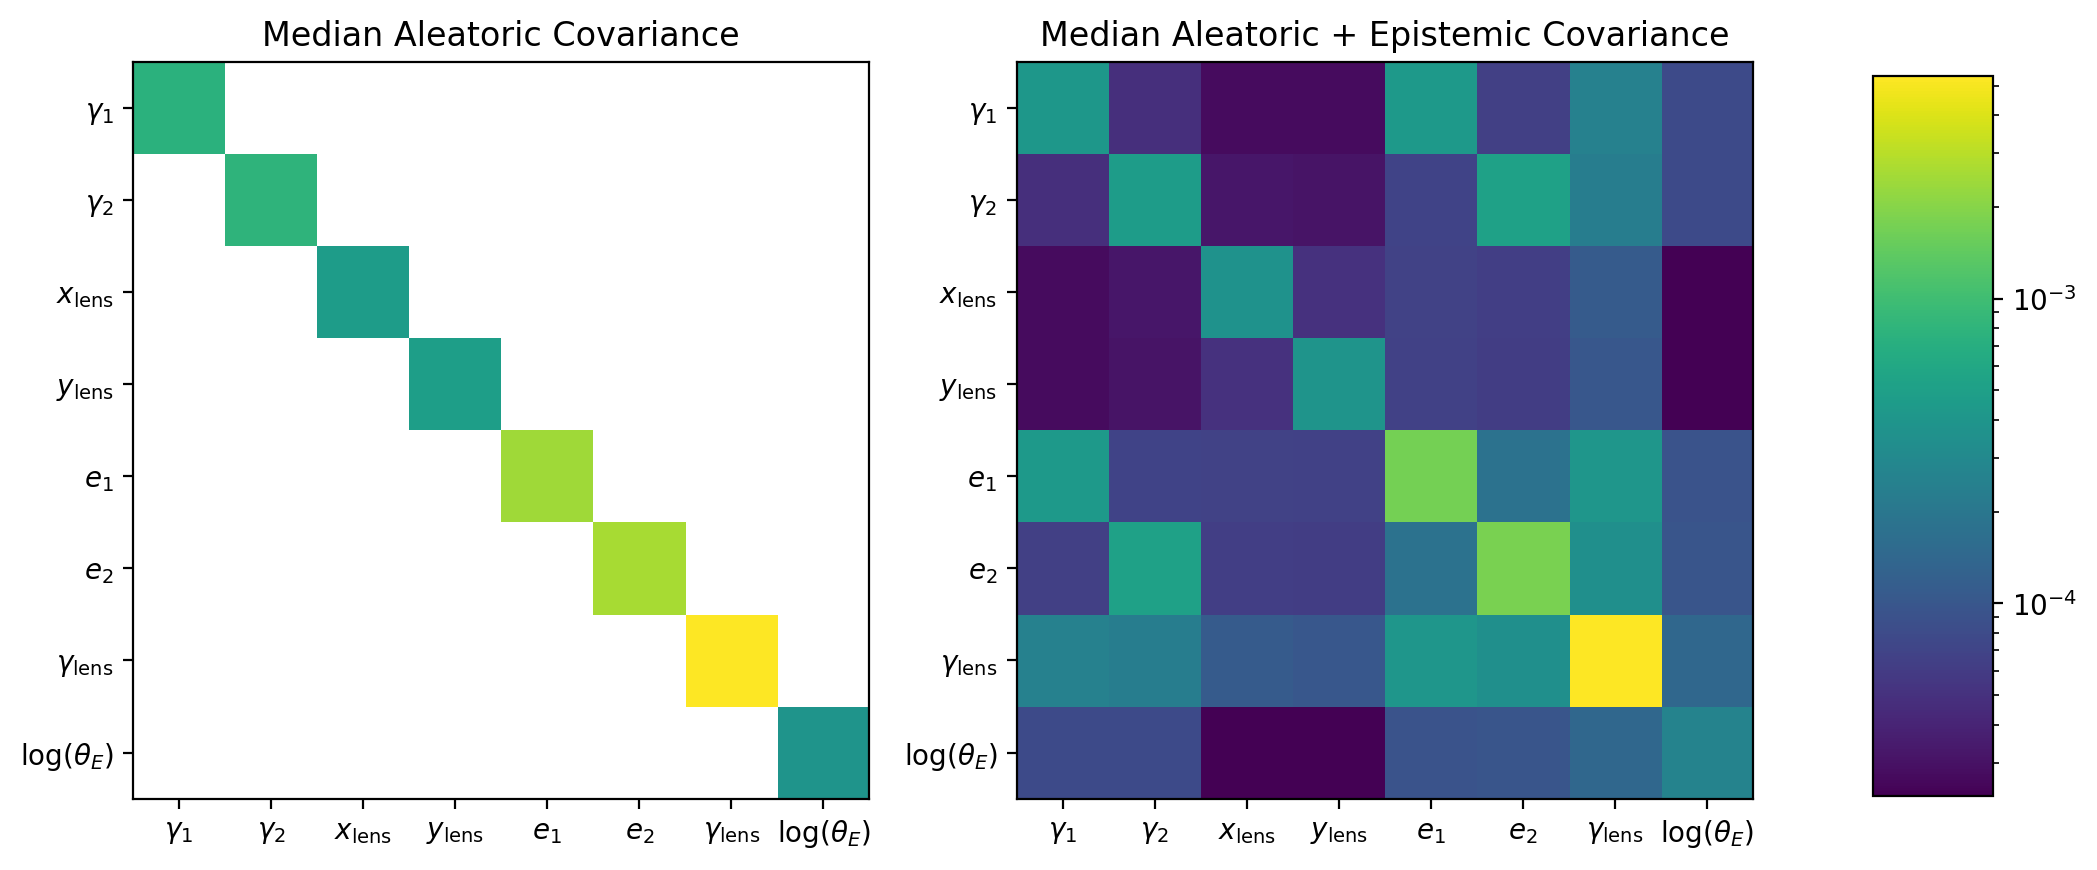

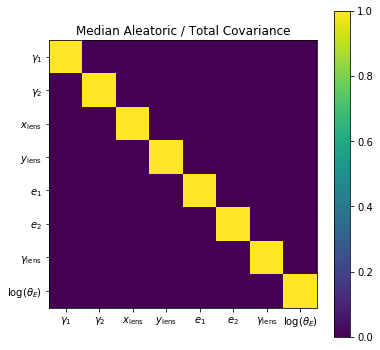

In [12]:
bnn_infer.comp_al_ep_unc(norm_diagonal=False)

## Diagonal Low Regularizer

In [13]:
config_path = root_path + 'configs/nn1_lr.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)
bnn_infer = bnn_inference.InferenceClass(cfg)
save_path_nn1_lr = root_path + 'validation_results/nn1_lr_samps/'
bnn_infer.gen_samples(num_samples,save_path_nn1_lr)

Is model built: True
Loaded weights /home/swagnercarena/ovejero/models/nn1_lr.h5
Loading samples from /home/swagnercarena/ovejero/validation_results/nn1_lr_samps/


In [14]:
bnn_infer.report_stats()

Parameter, RMSE, Median Abs Error, Median Std
external_shear_g1 0.030105276568032583 0.008866106652519768 0.01123406809273391
external_shear_g2 0.02366143658327769 0.008260931654483663 0.01153605194857912
lens_mass_center_x 0.012861566865537353 0.005081200208769367 0.008836971489232168
lens_mass_center_y 0.01561055320799136 0.0051994667608556006 0.008929233902725778
lens_mass_e1 0.03649735532584716 0.013875200835966904 0.020711442578298794
lens_mass_e2 0.03556411371451834 0.013007263146661584 0.02081126271392012
lens_mass_gamma 0.060258503470807606 0.030272257475057462 0.037707415671768746
lens_mass_theta_E_log 0.018649933549144806 0.0054122341624837575 0.008226950303079914


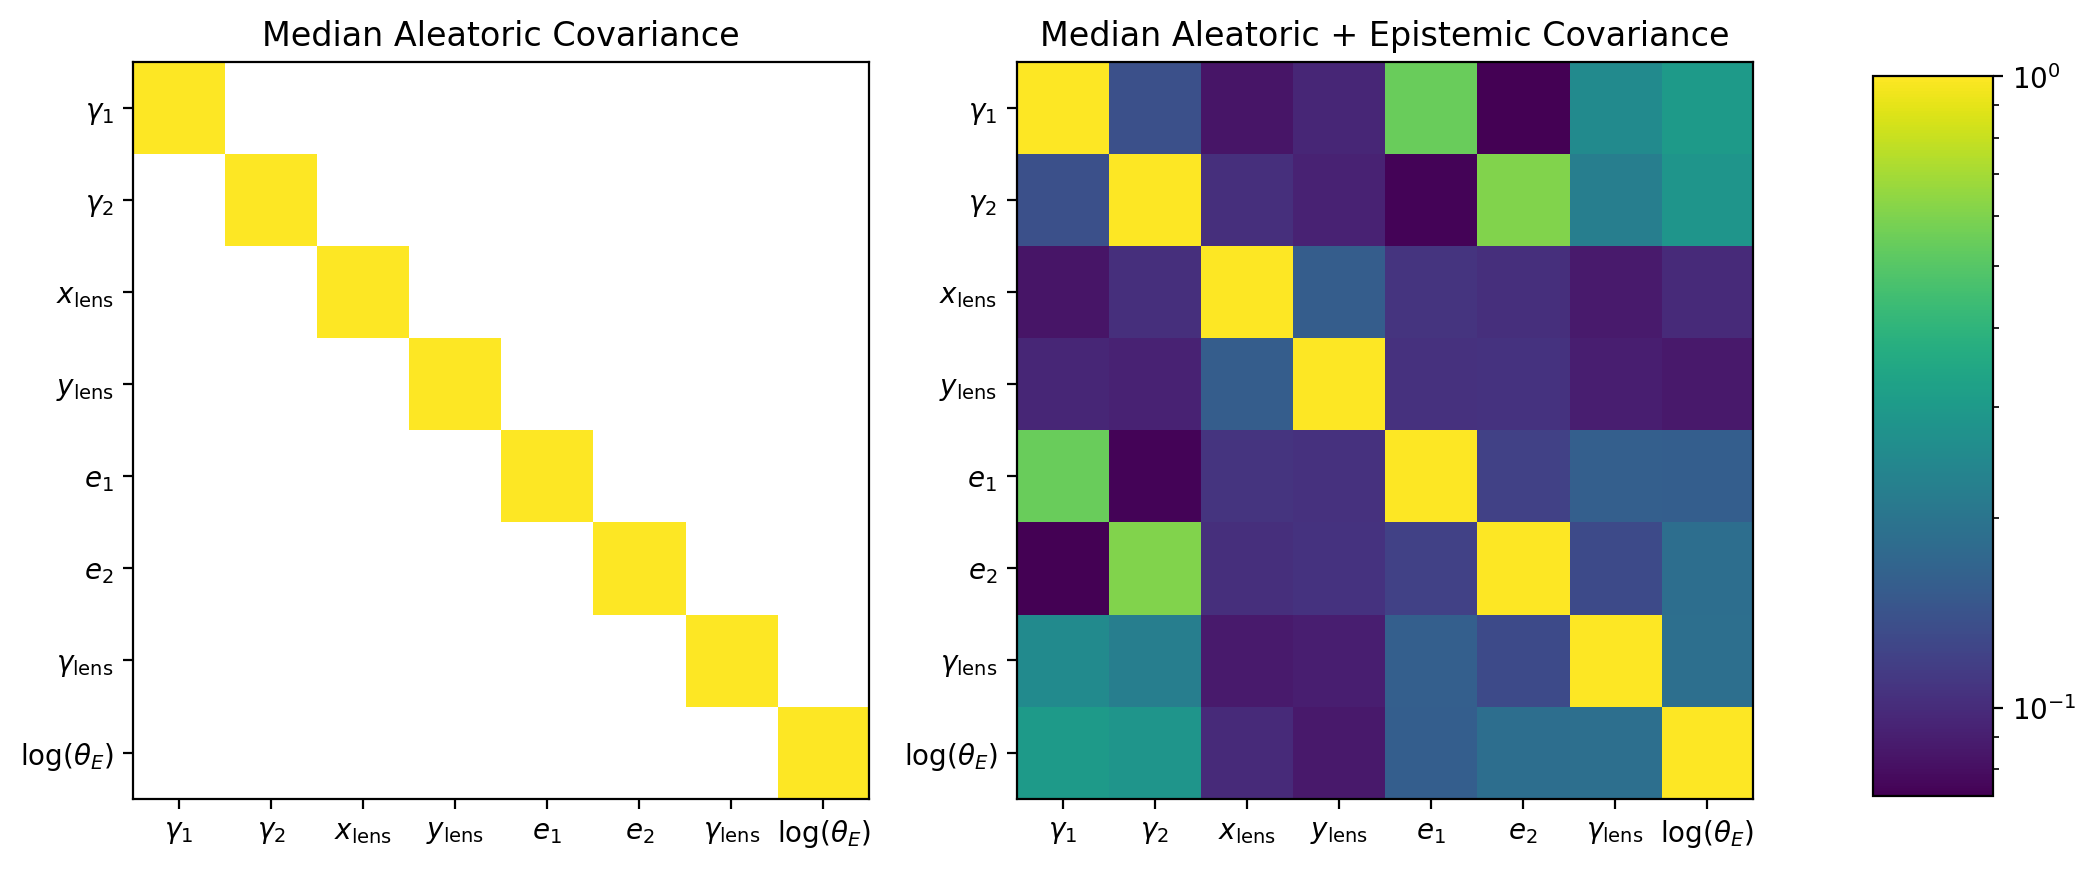

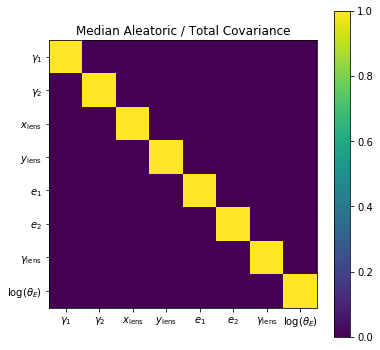

In [15]:
bnn_infer.comp_al_ep_unc(norm_diagonal=True)

## Comparison of Diagonals

Is model built: True
Loaded weights /home/swagnercarena/ovejero/models/nn1_lr.h5
Loading samples from /home/swagnercarena/ovejero/validation_results/nn1_lr_samps/
Is model built: True
Loaded weights /home/swagnercarena/ovejero/models/nn1.h5
Loading samples from /home/swagnercarena/ovejero/validation_results/nn1_samps/
Is model built: True
Loaded weights /home/swagnercarena/ovejero/models/nn1_hr.h5
Loading samples from /home/swagnercarena/ovejero/validation_results/nn1_hr_samps/


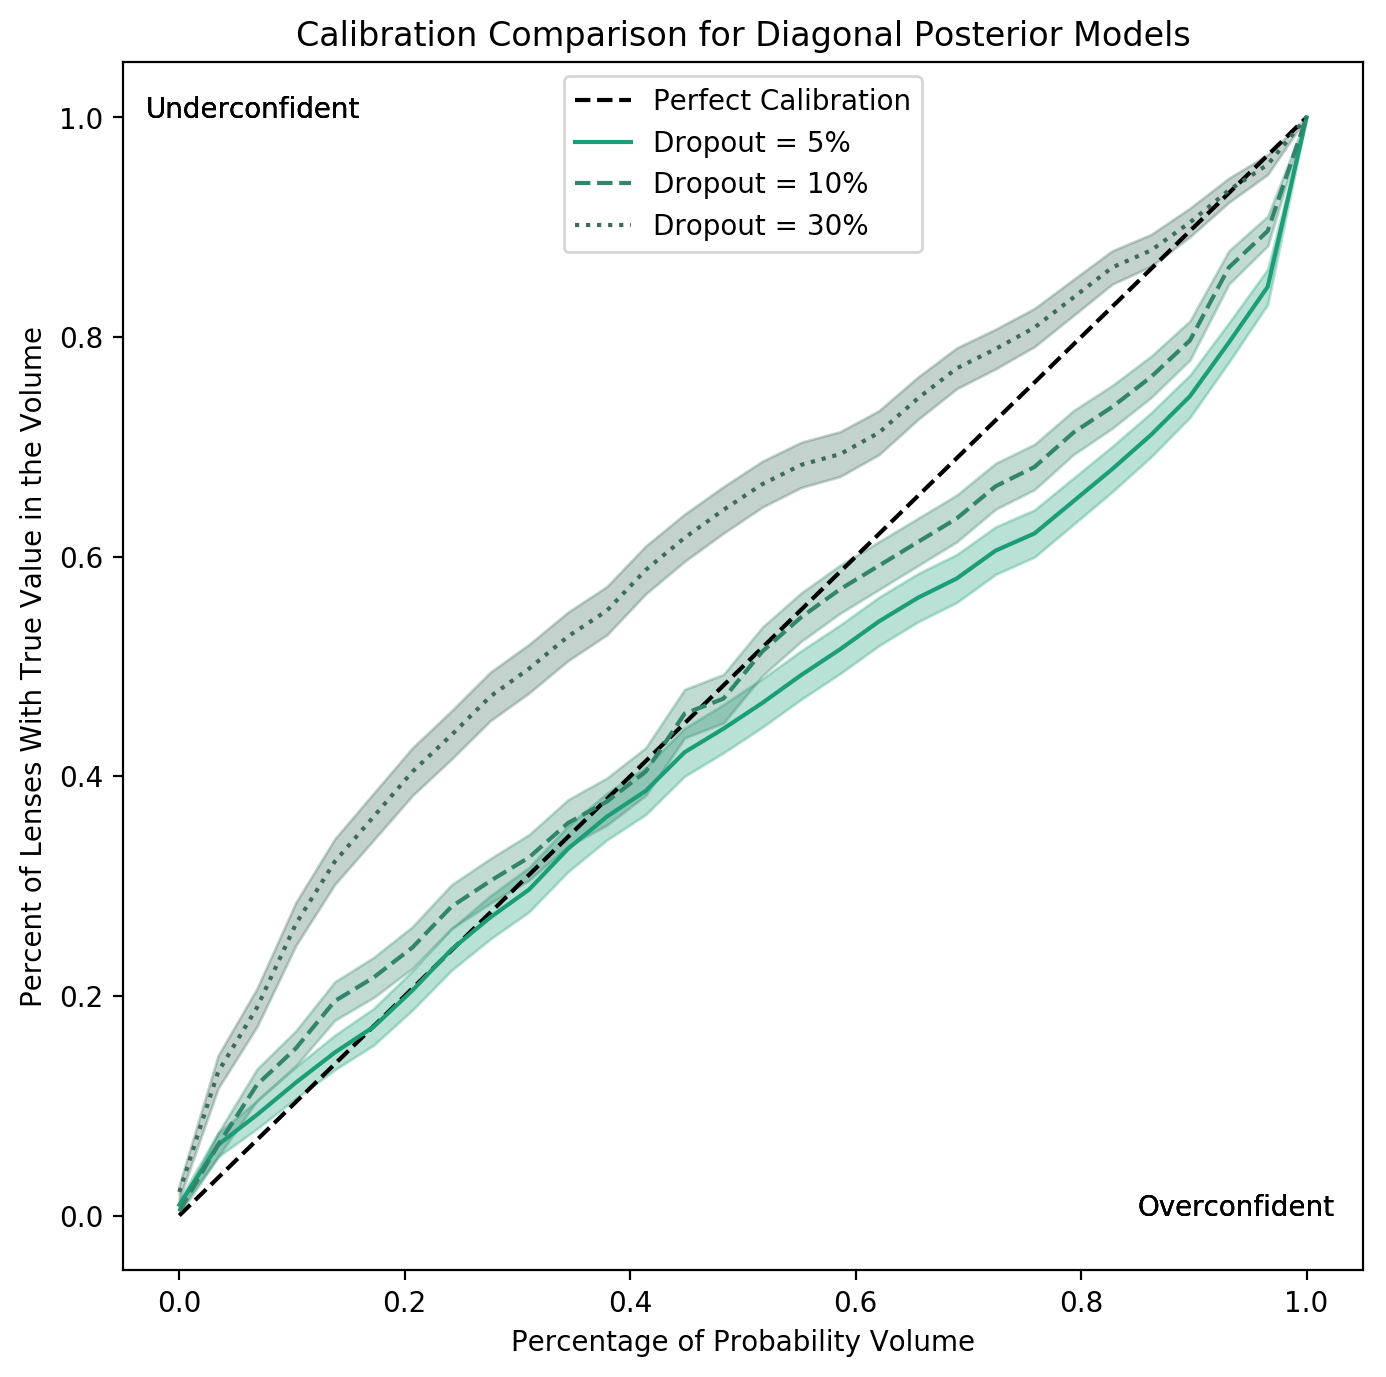

In [19]:
# color_map = ['#000000','#1b9e77','#d95f02','#7570b3','#e7298a']
color_map = ['#000000','#1b9e77','#32856c','#3d6b5d']
ls_list =['-','--',':']

# NN1_LR
config_path = root_path + 'configs/nn1_lr.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)
bnn_infer = bnn_inference.InferenceClass(cfg)
bnn_infer.gen_samples(num_samples,save_path_nn1_lr)
n_perc_points = 30
fig = bnn_infer.plot_calibration(color_map=color_map,n_perc_points=n_perc_points,show_plot=False,ls=ls_list[0])

# NN1
config_path = root_path + 'configs/nn1.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)
bnn_infer = bnn_inference.InferenceClass(cfg)
bnn_infer.gen_samples(num_samples,save_path_nn1)
fig = bnn_infer.plot_calibration(color_map=color_map[1:],n_perc_points=n_perc_points,figure=fig,show_plot=False,
                                ls=ls_list[1])

# NN1_HR
config_path = root_path + 'configs/nn1_hr.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)
bnn_infer = bnn_inference.InferenceClass(cfg)
bnn_infer.gen_samples(num_samples,save_path_nn1_hr)
fig = bnn_infer.plot_calibration(color_map=color_map[2:],n_perc_points=n_perc_points,figure=fig,show_plot=False,
                                legend=['Perfect Calibration',r'Dropout = 5%',r'Dropout = 10%',
                                       r'Dropout = 30%'],
                                 title='Calibration Comparison for Diagonal Posterior Models',
                                ls=ls_list[2])
save_cal_path = 'figures/diag_cal.pdf'
plt.savefig(save_cal_path)
plt.show()

## Full Posterior

In [58]:
config_path = root_path + 'configs/nn2.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)
bnn_infer = bnn_inference.InferenceClass(cfg)
save_path_nn2 = root_path + 'validation_results/nn2_samps/'
bnn_infer.gen_samples(num_samples,save_path_nn2)

Is model built: True
Loaded weights /home/swagnercarena/ovejero/models/nn2.h5
Loading samples from /home/swagnercarena/ovejero/validation_results/nn2_samps/


In [59]:
bnn_infer.report_stats()

Parameter, RMSE, Median Abs Error, Median Std
external_shear_g1 0.05103831188558377 0.007938813903351761 0.014200486460589513
external_shear_g2 0.022551655674674494 0.008033345960022637 0.014982539837585162
lens_mass_center_x 0.013679276019579883 0.005525077839296868 0.009272347609617777
lens_mass_center_y 0.016606881367405766 0.005024644058136449 0.009478016647725879
lens_mass_e1 0.03858194885358332 0.014074927567396598 0.02491893053602793
lens_mass_e2 0.03701790879821679 0.013420652016271328 0.025338026965059456
lens_mass_gamma 0.06020288420821575 0.027037738171809544 0.04991016372629627
lens_mass_theta_E_log 0.024085772722425448 0.004653805848121944 0.009715045482430112


In [61]:
# bnn_infer.gen_coverage_plots(num_lenses=num_lenses)

In [ ]:
image_index = 21
bnn_infer.plot_posterior_contours(image_index)

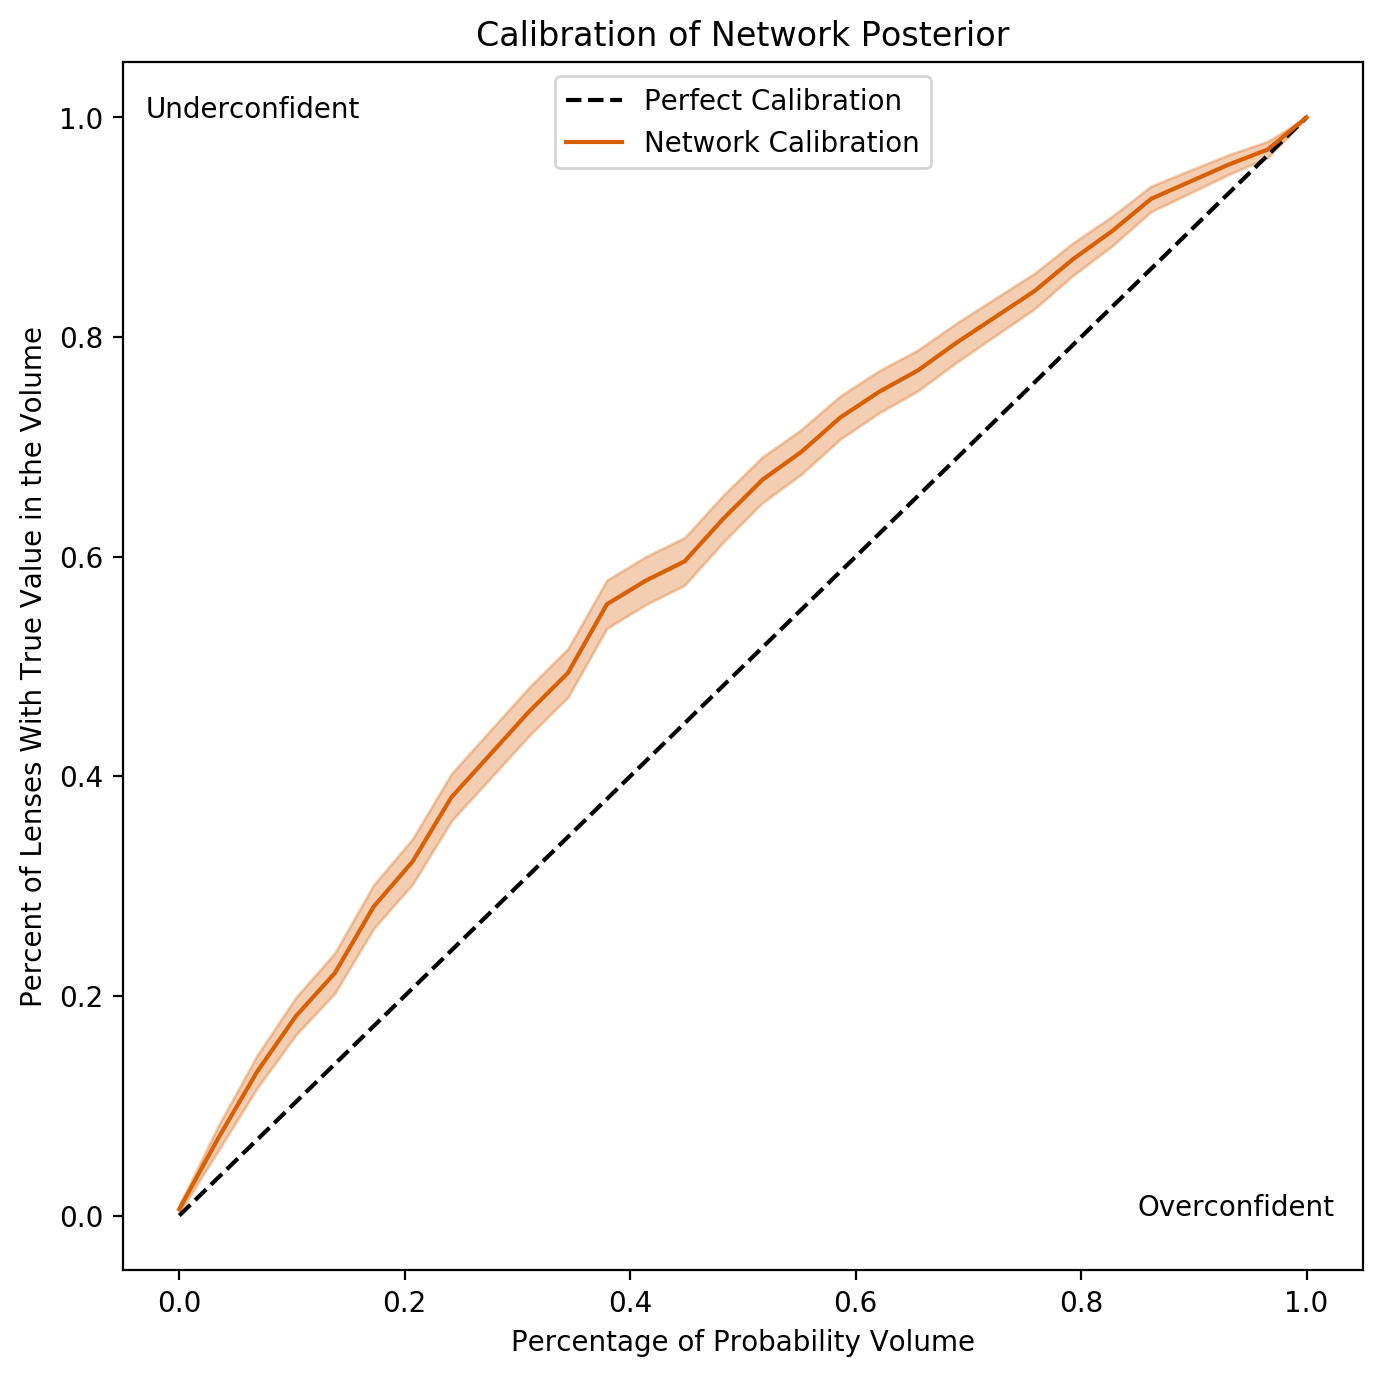

In [62]:
color_map = ['#000000','#d95f02']
n_perc_points = 30
fig = bnn_infer.plot_calibration(color_map=color_map,n_perc_points=n_perc_points,show_plot=False)

## Full Posterior Low Regularization

In [63]:
config_path = root_path + 'configs/nn2_lr.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)
bnn_infer = bnn_inference.InferenceClass(cfg)
save_path_nn2_lr = root_path + 'validation_results/nn2_lr_samps/'
bnn_infer.gen_samples(num_samples,save_path_nn2_lr)

Is model built: True
Loaded weights /home/swagnercarena/ovejero/models/nn2_lr.h5
Loading samples from /home/swagnercarena/ovejero/validation_results/nn2_lr_samps/


In [64]:
bnn_infer.report_stats()

Parameter, RMSE, Median Abs Error, Median Std
external_shear_g1 0.056338819361108926 0.00774882861263557 0.012423234312867217
external_shear_g2 0.02351153505951372 0.007927196359555522 0.013148081798636671
lens_mass_center_x 0.012442916388207258 0.00493287636662855 0.007986419015908474
lens_mass_center_y 0.015317740945408893 0.00494273180338509 0.00792293991987473
lens_mass_e1 0.03966675337516573 0.014011606839195667 0.021132620651050385
lens_mass_e2 0.03613259811627241 0.013460957373107523 0.020756783223707356
lens_mass_gamma 0.05398274882988443 0.02557433792980468 0.04478370961283494
lens_mass_theta_E_log 0.02540032915559671 0.005035758579988505 0.007922896659259472


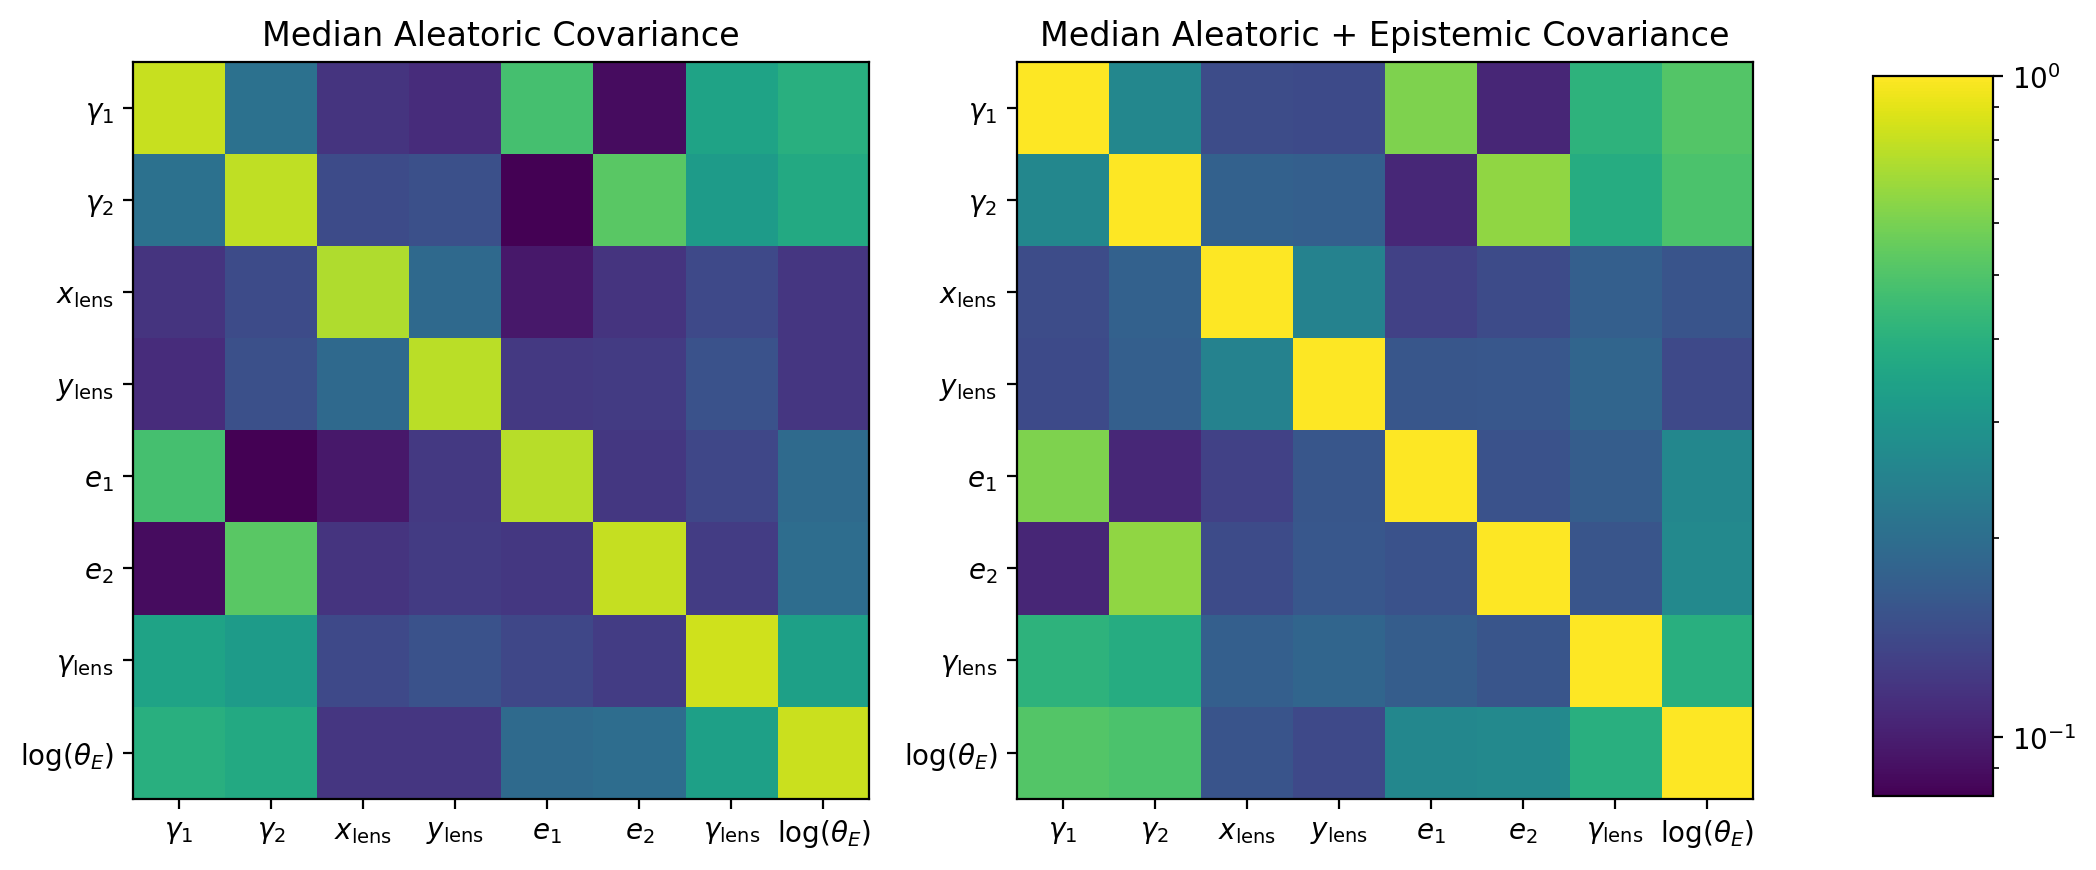

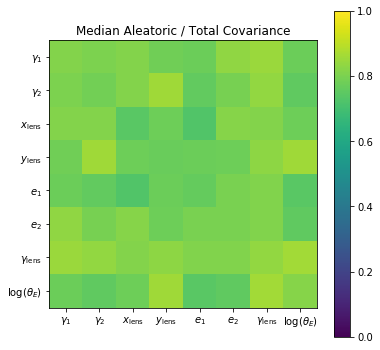

In [65]:
bnn_infer.comp_al_ep_unc()

## Full Posterior High Regularization

In [66]:
config_path = root_path + 'configs/nn2_hr.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)
bnn_infer = bnn_inference.InferenceClass(cfg)
save_path_nn2_hr = root_path + 'validation_results/nn2_hr_samps/'
bnn_infer.gen_samples(num_samples,save_path_nn2_hr)

Is model built: True
Loaded weights /home/swagnercarena/ovejero/models/nn2_hr.h5
Loading samples from /home/swagnercarena/ovejero/validation_results/nn2_hr_samps/


In [67]:
bnn_infer.report_stats()

Parameter, RMSE, Median Abs Error, Median Std
external_shear_g1 0.037559259804735 0.00825330798472955 0.01732030133500282
external_shear_g2 0.022180590960881704 0.008584002018172589 0.01788417767127174
lens_mass_center_x 0.01406354352773393 0.005133013375458139 0.01192776219493659
lens_mass_center_y 0.016129634674500567 0.004969057992254104 0.01215105235954895
lens_mass_e1 0.03821787941086114 0.014466740058477215 0.029702218686038936
lens_mass_e2 0.035012308772567974 0.014089994938252009 0.02992604235175332
lens_mass_gamma 0.05978701018430139 0.030261862868719014 0.056559784938541774
lens_mass_theta_E_log 0.021383534518352967 0.005336883521255255 0.011646316254888205


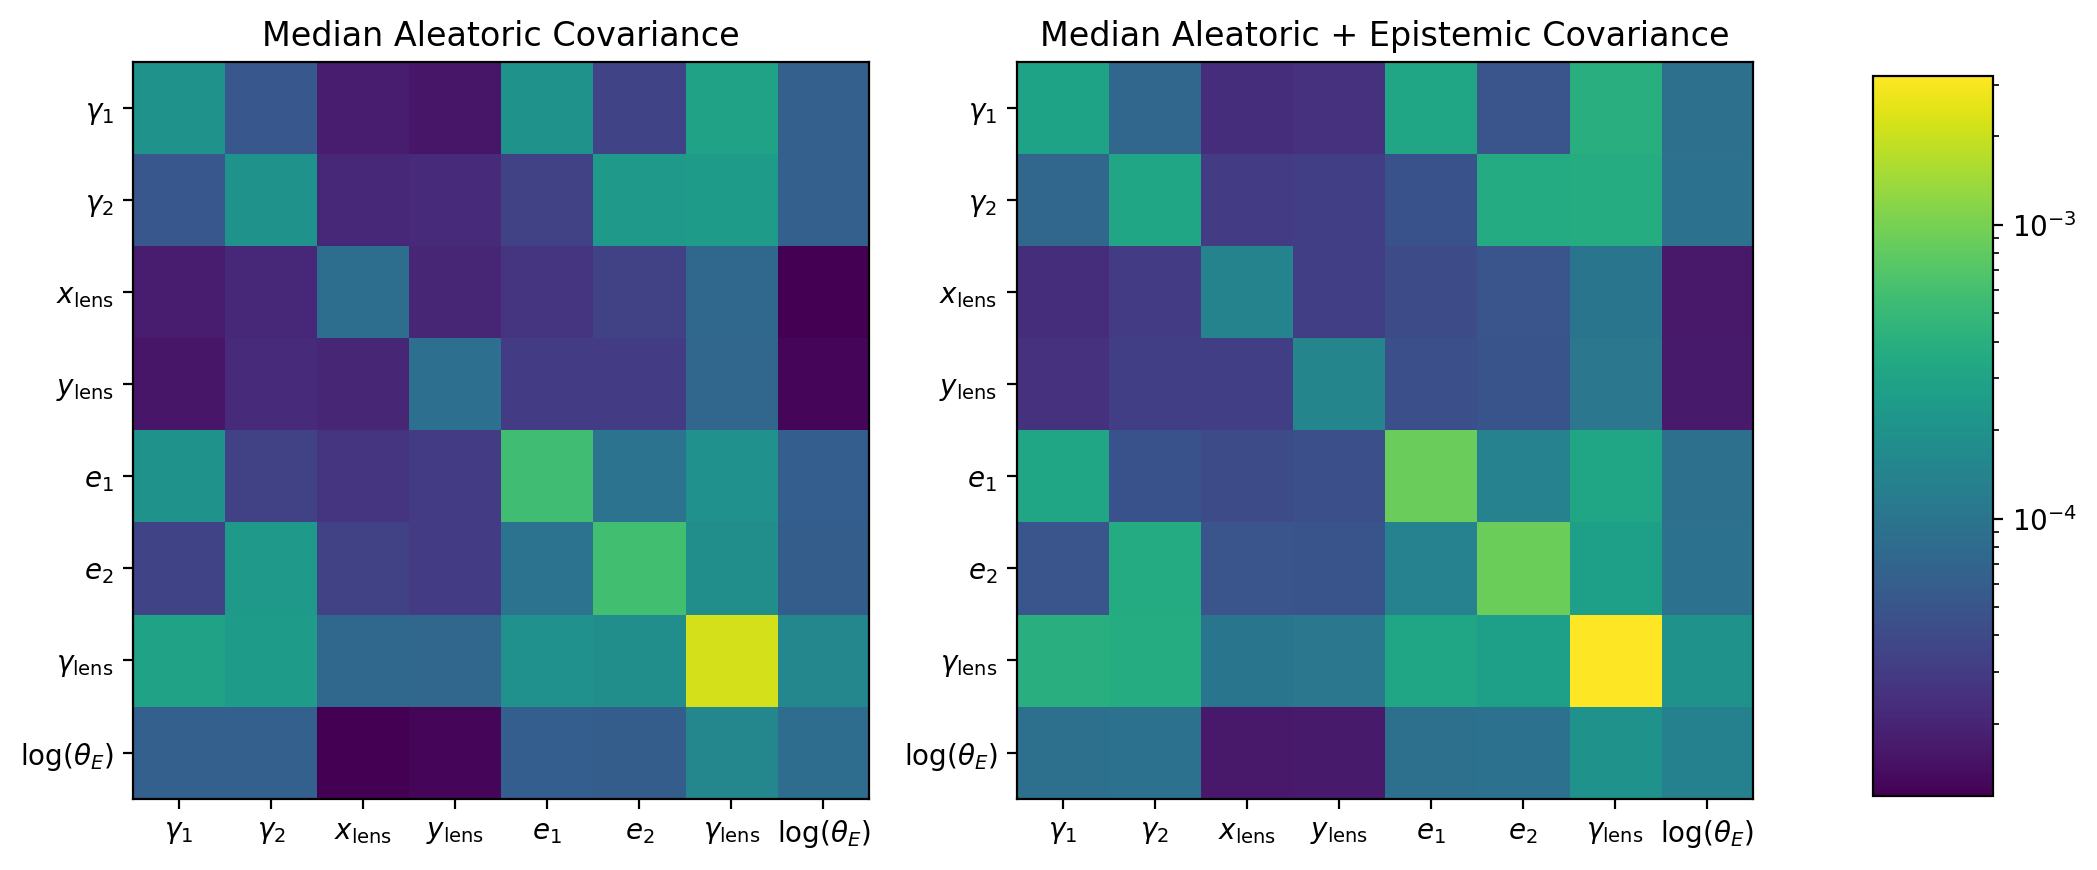

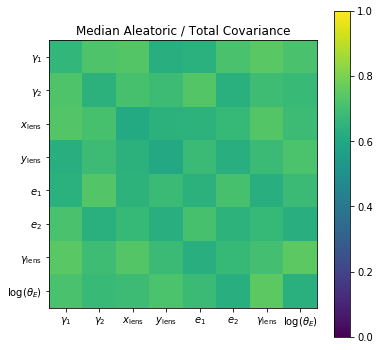

In [68]:
bnn_infer.comp_al_ep_unc(norm_diagonal=False)

## Full Posterior No Regularization

In [69]:
config_path = root_path + 'configs/nn2_zr.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)
bnn_infer = bnn_inference.InferenceClass(cfg)
save_path_nn2_zr = root_path + 'validation_results/nn2_zr_samps/'
bnn_infer.gen_samples(num_samples,save_path_nn2_zr)

Is model built: True
Loaded weights /home/swagnercarena/ovejero/models/nn2_zr.h5
Loading samples from /home/swagnercarena/ovejero/validation_results/nn2_zr_samps/


In [70]:
bnn_infer.report_stats()

Parameter, RMSE, Median Abs Error, Median Std
external_shear_g1 0.06880218831380756 0.010792417328428129 0.015011041392314529
external_shear_g2 0.03366950981498706 0.010447122982091557 0.015502609339165176
lens_mass_center_x 0.017011234019444686 0.006639314905621924 0.007832032524381282
lens_mass_center_y 0.023294075673785997 0.006390290862814372 0.008781232031847754
lens_mass_e1 0.05160662895148784 0.01930053905285662 0.026126962211225287
lens_mass_e2 0.044777612065496644 0.017825037674541116 0.026544159197940342
lens_mass_gamma 0.0727810997099681 0.03557143980048805 0.05587608605709404
lens_mass_theta_E_log 0.03217903972752165 0.006492306170654997 0.008812197969074603


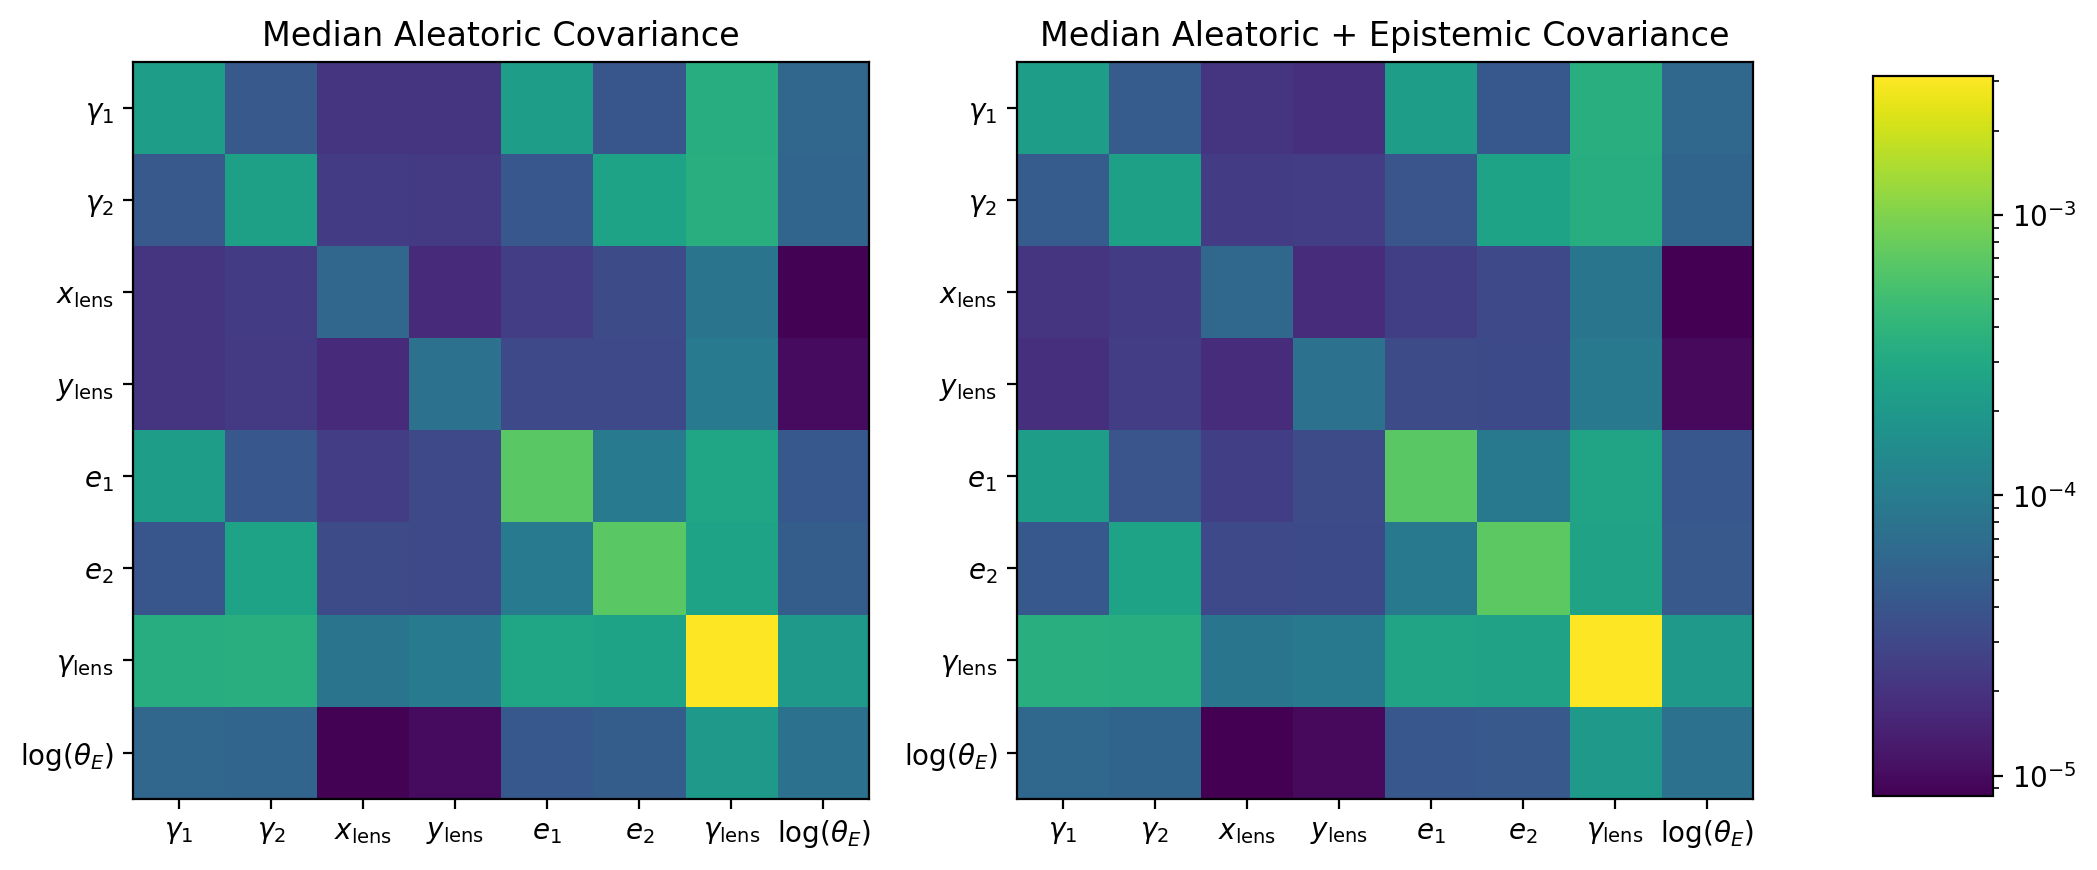

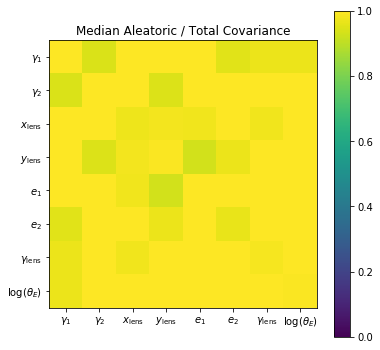

In [73]:
bnn_infer.comp_al_ep_unc(norm_diagonal=False)

## Full Posterior 0.1% Regularization

In [34]:
config_path = root_path + 'configs/nn2_slr.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)
bnn_infer = bnn_inference.InferenceClass(cfg)
save_path_nn2_slr = root_path + 'validation_results/nn2_slr_samps/'
bnn_infer.gen_samples(num_samples,save_path_nn2_slr)

Is model built: True
Loaded weights /home/swagnercarena/ovejero/models/nn2_slr.h5
Loading samples from /home/swagnercarena/ovejero/validation_results/nn2_slr_samps/


In [35]:
bnn_infer.report_stats()

Parameter, RMSE, Median Abs Error, Median Std
external_shear_g1 0.06169029865162176 0.00918278285229972 0.013198391621898717
external_shear_g2 0.03047982696780259 0.008640505796268353 0.013659037619363164
lens_mass_center_x 0.014058033221087033 0.0057260775535828215 0.007768289267615875
lens_mass_center_y 0.01873295169489713 0.0059447210064102925 0.007913615166943052
lens_mass_e1 0.046370993699461883 0.014581822302427147 0.023152961999684932
lens_mass_e2 0.04098769338949782 0.0167601633453017 0.022555812356133634
lens_mass_gamma 0.06176700164392977 0.02943562562186597 0.04729566945854238
lens_mass_theta_E_log 0.029254803542761894 0.005334725597672799 0.008289678868217139


## Comparison of Fulls

Is model built: True
Loaded weights /home/swagnercarena/ovejero/models/nn2_zr.h5
Loading samples from /home/swagnercarena/ovejero/validation_results/nn2_zr_samps/
Is model built: True
Loaded weights /home/swagnercarena/ovejero/models/nn2_slr.h5
Loading samples from /home/swagnercarena/ovejero/validation_results/nn2_slr_samps/
Is model built: True
Loaded weights /home/swagnercarena/ovejero/models/nn2_lr.h5
Loading samples from /home/swagnercarena/ovejero/validation_results/nn2_lr_samps/
Is model built: True
Loaded weights /home/swagnercarena/ovejero/models/nn2.h5
Loading samples from /home/swagnercarena/ovejero/validation_results/nn2_samps/


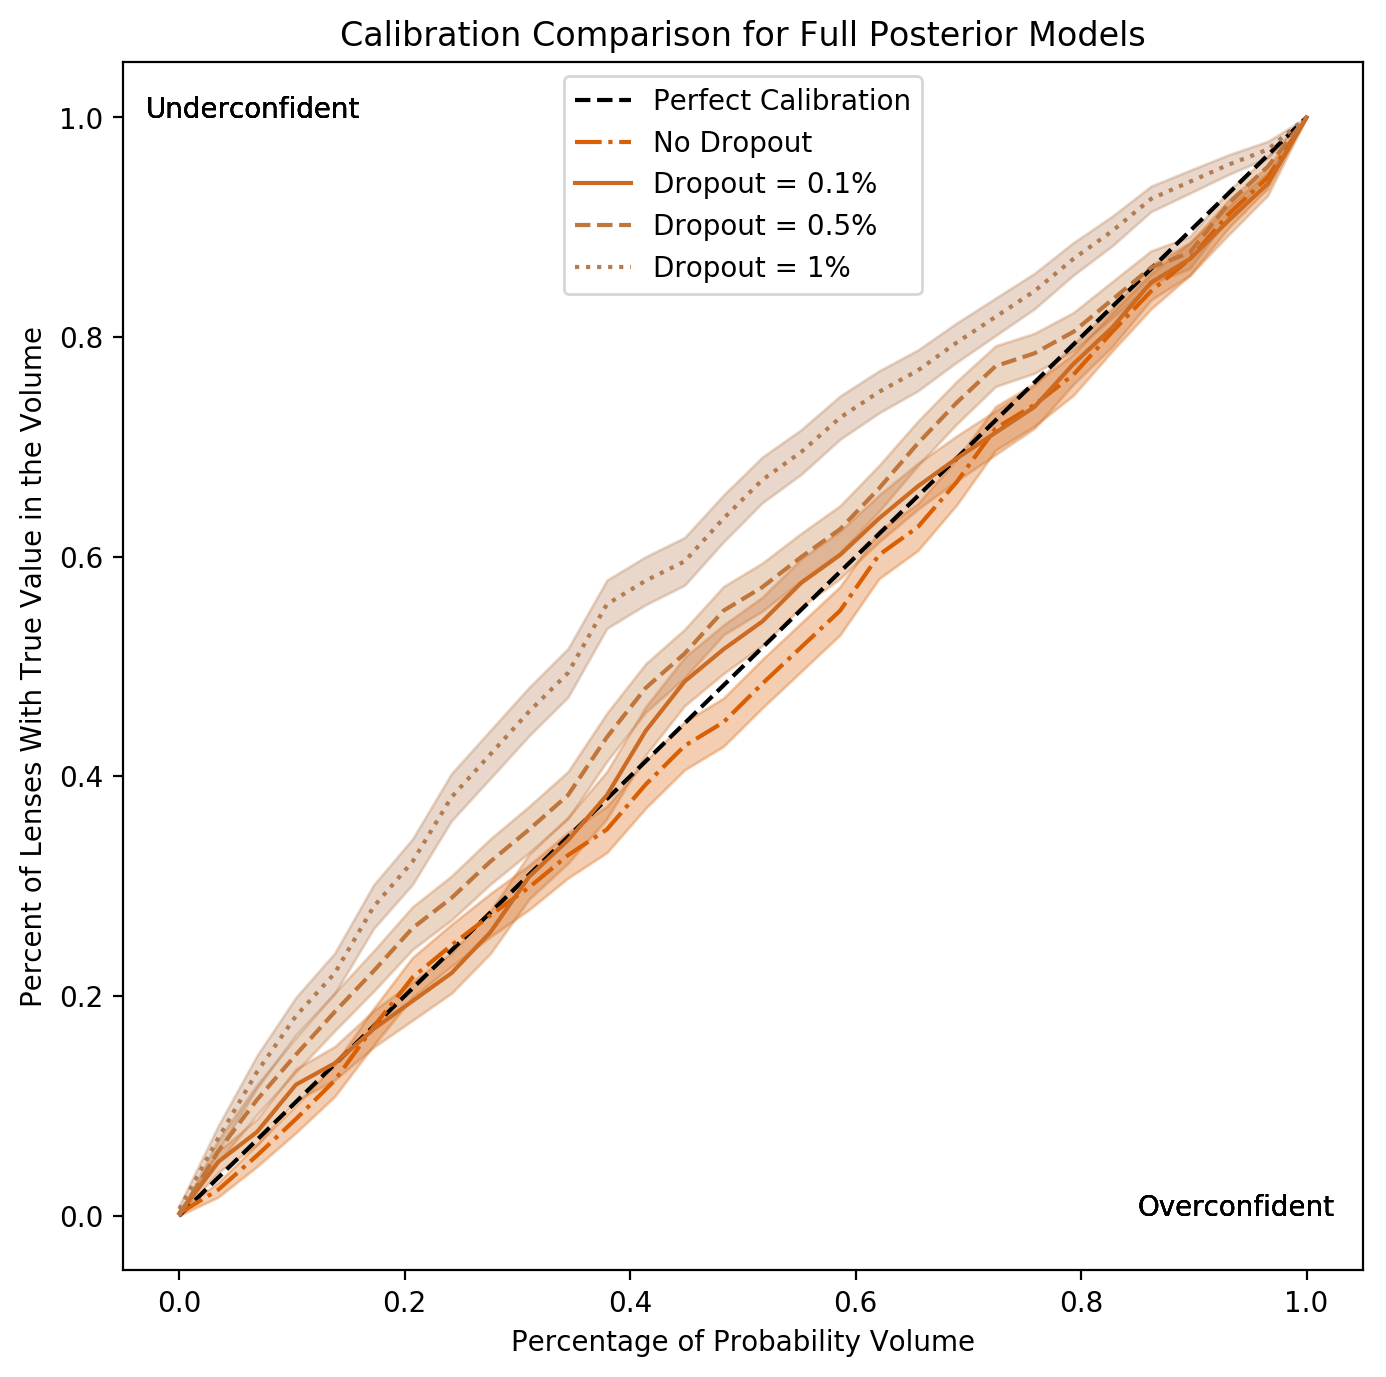

In [36]:
# color_map = ['#000000','#1b9e77','#d95f02','#7570b3','#e7298a']
color_map = ['#000000','#d95f02','#cc6b21','#c0753b','#b37c52']
ls_list =['-.','-','--',':']

# NN2_ZR
config_path = root_path + 'configs/nn2_zr.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)
bnn_infer = bnn_inference.InferenceClass(cfg)
bnn_infer.gen_samples(num_samples,save_path_nn2_zr)
fig = bnn_infer.plot_calibration(color_map=color_map,n_perc_points=n_perc_points,show_plot=False,
                                 ls=ls_list[0])

# NN2_SLR
config_path = root_path + 'configs/nn2_slr.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)
bnn_infer = bnn_inference.InferenceClass(cfg)
bnn_infer.gen_samples(num_samples,save_path_nn2_slr)
n_perc_points = 30
fig = bnn_infer.plot_calibration(color_map=color_map[1:],n_perc_points=n_perc_points,figure=fig,show_plot=False,
                                 ls=ls_list[1])

# NN2_LR
config_path = root_path + 'configs/nn2_lr.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)
bnn_infer = bnn_inference.InferenceClass(cfg)
bnn_infer.gen_samples(num_samples,save_path_nn2_lr)
fig = bnn_infer.plot_calibration(color_map=color_map[2:],n_perc_points=n_perc_points,figure=fig,show_plot=False,
                                ls=ls_list[2])

# NN2
config_path = root_path + 'configs/nn2.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)
bnn_infer = bnn_inference.InferenceClass(cfg)
bnn_infer.gen_samples(num_samples,save_path_nn2)
fig = bnn_infer.plot_calibration(color_map=color_map[3:],n_perc_points=n_perc_points,figure=fig,show_plot=False,
                                legend=['Perfect Calibration',r'No Dropout',r'Dropout = 0.1%',r'Dropout = 0.5%',
                                       r'Dropout = 1%'],
                                 title='Calibration Comparison for Full Posterior Models',ls=ls_list[3])
save_cal_path = 'figures/full_cal.pdf'
plt.savefig(save_cal_path)
plt.show()

## GM Posterior

In [3]:
# First specify the config path
config_path = root_path + 'configs/nn3.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)
bnn_infer = bnn_inference.InferenceClass(cfg)
num_samples = 1000
save_path_nn3 = root_path + 'validation_results/nn3_samps/'
bnn_infer.gen_samples(num_samples,save_path_nn3)

Is model built: True
Loaded weights /home/swagnercarena/ovejero/models/nn3.h5
Loading samples from /home/swagnercarena/ovejero/validation_results/nn3_samps/


In [4]:
bnn_infer.report_stats()

Parameter, RMSE, Median Abs Error, Median Std
external_shear_g1 0.0477275023980844 0.007713530723261693 0.01374397077504962
external_shear_g2 0.020399992742024427 0.007611457295602261 0.013962421222985058
lens_mass_center_x 0.01250355000197491 0.004473394492097146 0.008847738106150527
lens_mass_center_y 0.016696653930615927 0.004601031237911973 0.008807755693414056
lens_mass_e1 0.03620145559404158 0.012831454719275819 0.02317483805735851
lens_mass_e2 0.03494782307018956 0.011427298040775857 0.02347070823086251
lens_mass_gamma 0.05419600844116478 0.02733444793563211 0.04616749393932445
lens_mass_theta_E_log 0.02438787350910717 0.004949216678652885 0.008928833936672233


In [40]:
# bnn_infer.gen_coverage_plots(num_lenses=num_lenses)

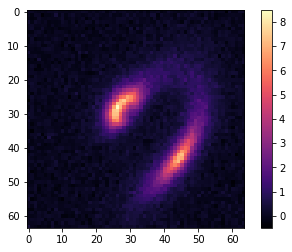

external_shear_g1 -0.0019446439
external_shear_g2 -0.1220737
lens_mass_center_x 0.0191754
lens_mass_center_y -0.046357926
lens_mass_e1 0.036115054
lens_mass_e2 -0.46795967
lens_mass_gamma 1.9052159
lens_mass_theta_E_log -0.016758852


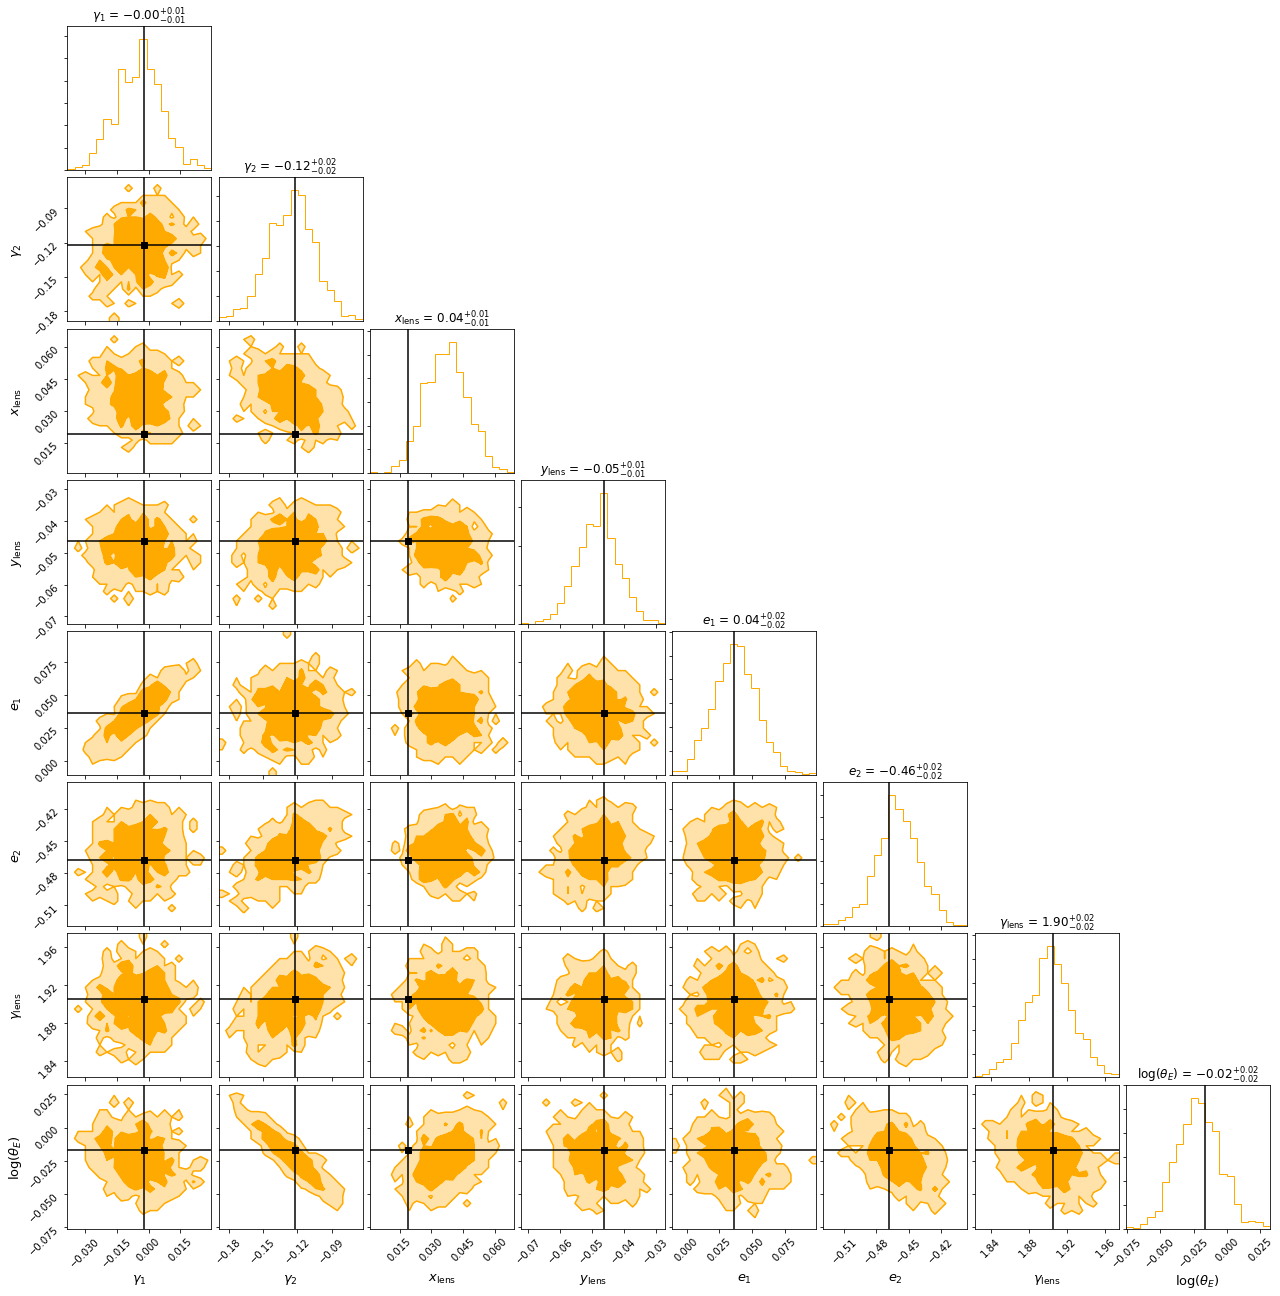

In [41]:
image_index = 20
bnn_infer.plot_posterior_contours(image_index)

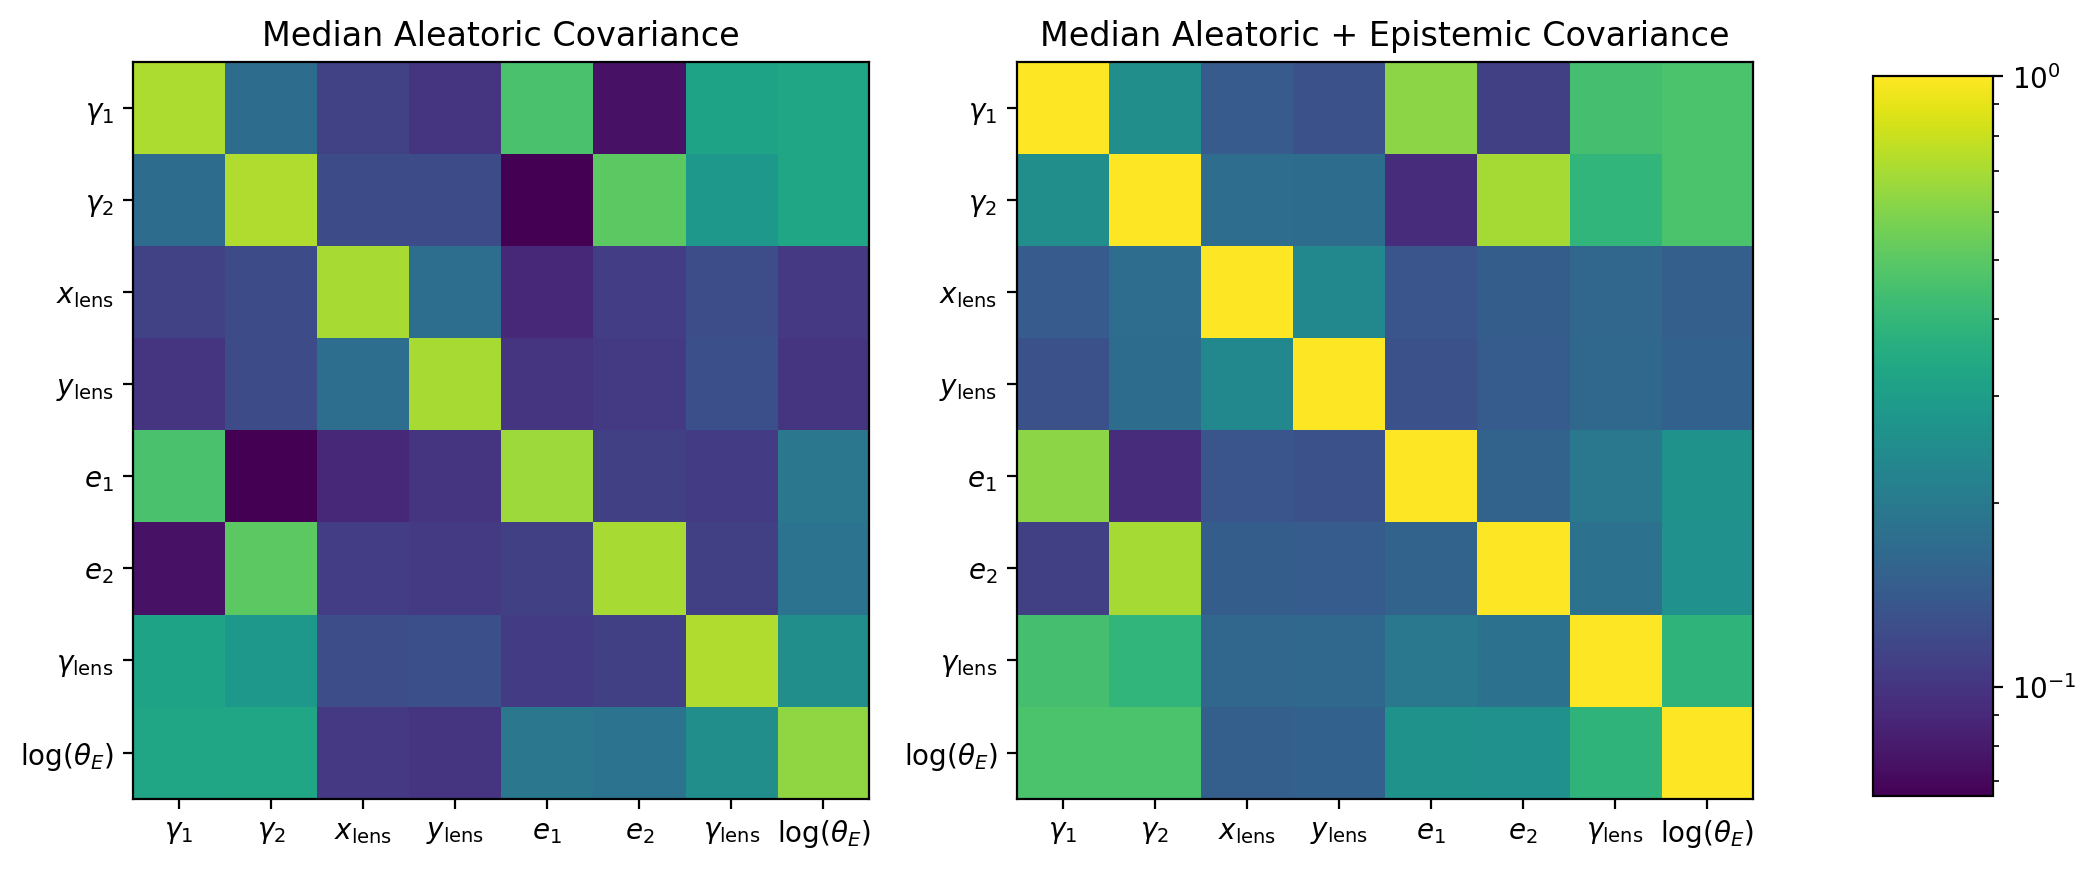

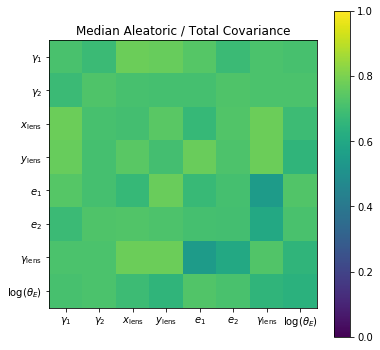

In [42]:
bnn_infer.comp_al_ep_unc()

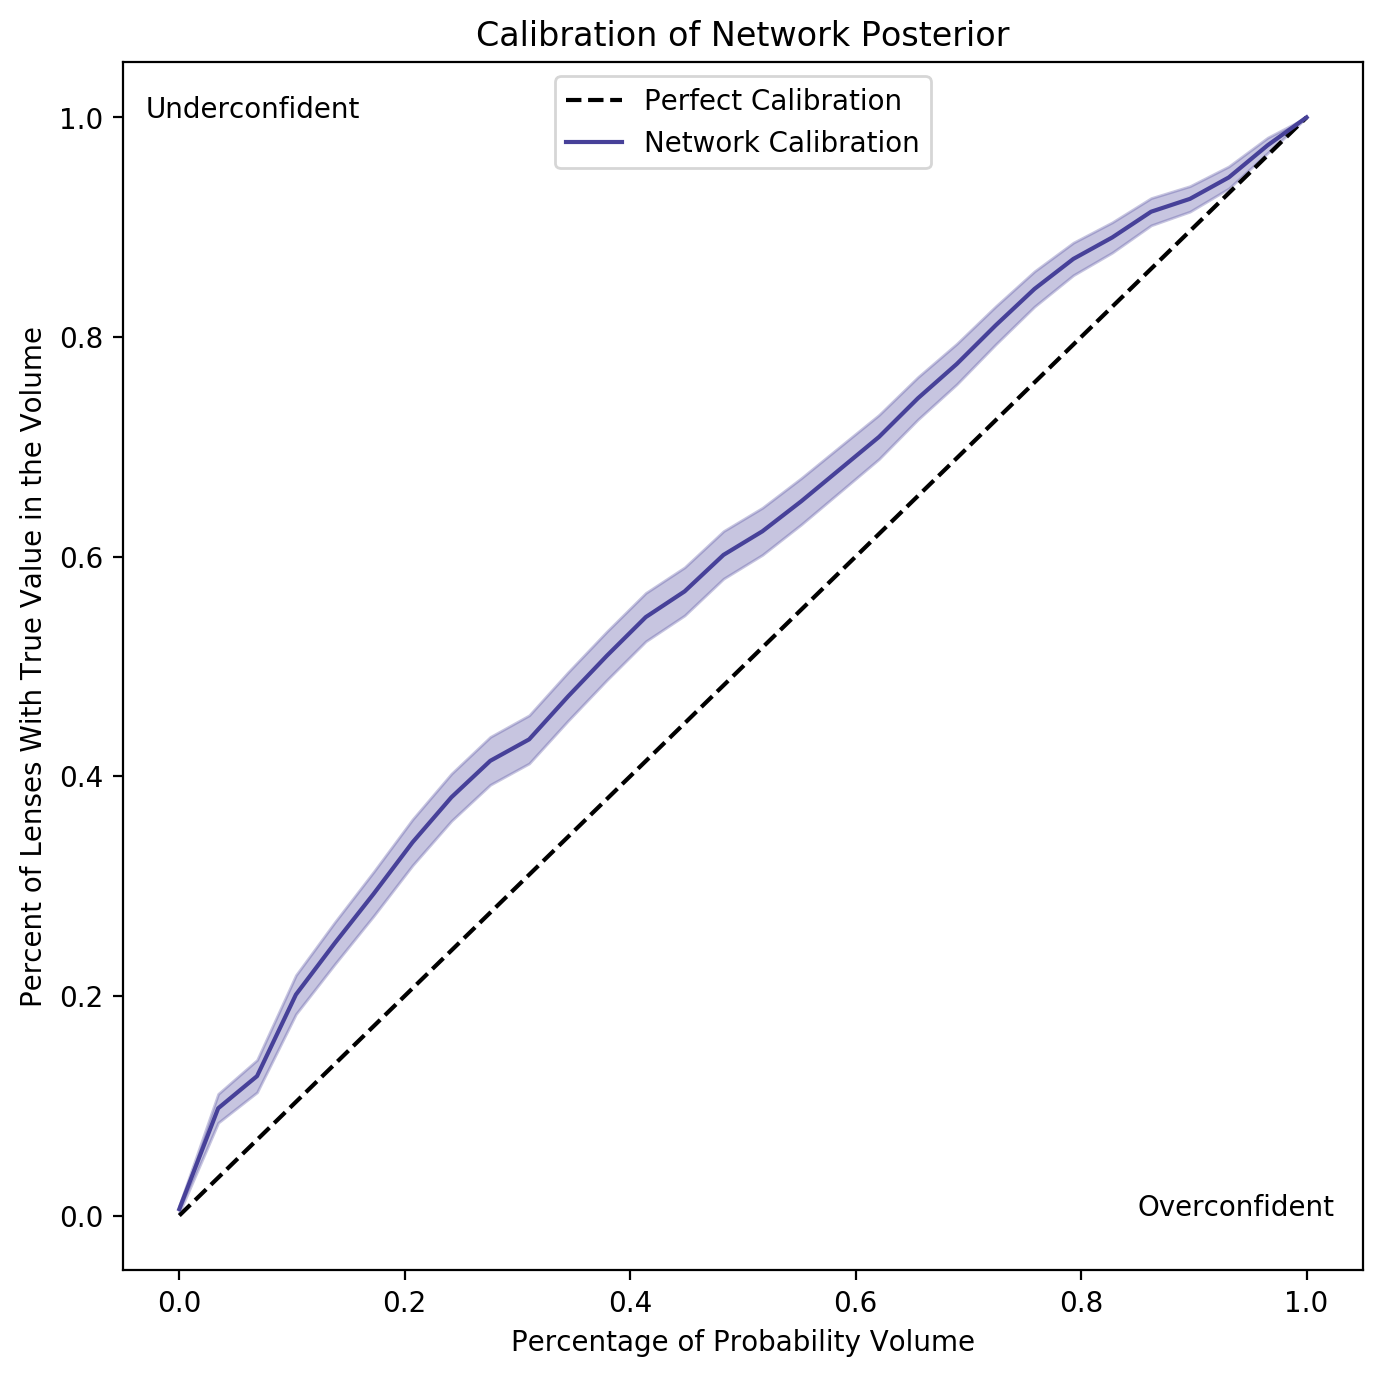

In [5]:
color_map = ['#000000','#474199']
n_perc_points = 30
fig = bnn_infer.plot_calibration(color_map=color_map,n_perc_points=n_perc_points,show_plot=False)

## GMM High Regularization

In [44]:
config_path = root_path + 'configs/nn3_hr.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)
bnn_infer = bnn_inference.InferenceClass(cfg)
save_path_nn3_hr = root_path + 'validation_results/nn3_hr_samps/'
bnn_infer.gen_samples(num_samples,save_path_nn3_hr)

Is model built: True
Loaded weights /home/swagnercarena/ovejero/models/nn3_hr.h5
Loading samples from /home/swagnercarena/ovejero/validation_results/nn3_hr_samps/


In [45]:
bnn_infer.report_stats()

Parameter, RMSE, Median Abs Error, Median Std
external_shear_g1 0.03665491596358664 0.007924204119672585 0.01737850543745236
external_shear_g2 0.020062645035362144 0.00791280936625962 0.017910126848140268
lens_mass_center_x 0.012296335227425226 0.005000885794987905 0.011922578289981826
lens_mass_center_y 0.015713339502983013 0.0052219748163998825 0.012169066157589892
lens_mass_e1 0.03748986819221288 0.014321208660119024 0.03034029944667846
lens_mass_e2 0.03494296332386686 0.012634776245383623 0.03065480464840853
lens_mass_gamma 0.05875167246795856 0.029915178479201332 0.05722689676341566
lens_mass_theta_E_log 0.020660407391794665 0.005017662331546498 0.011915587852580015


## GMM Low Regularization

In [46]:
config_path = root_path + 'configs/nn3_lr.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)
bnn_infer = bnn_inference.InferenceClass(cfg)
save_path_nn3_lr = root_path + 'validation_results/nn3_lr_samps/'
bnn_infer.gen_samples(num_samples,save_path_nn3_lr)

Is model built: True
Loaded weights /home/swagnercarena/ovejero/models/nn3_lr.h5
Loading samples from /home/swagnercarena/ovejero/validation_results/nn3_lr_samps/


In [47]:
bnn_infer.report_stats()

Parameter, RMSE, Median Abs Error, Median Std
external_shear_g1 0.05464483290674998 0.0074848299253928025 0.01254857215408764
external_shear_g2 0.022084942287867615 0.007955345125732835 0.012960871069035235
lens_mass_center_x 0.013109669652452735 0.0043135968688494675 0.007871065774335821
lens_mass_center_y 0.01668113776113687 0.004963551149151811 0.0078880535067083
lens_mass_e1 0.03799433779016042 0.013628653712871253 0.020768866104312066
lens_mass_e2 0.03807519860127171 0.01313539218892601 0.02125123193427824
lens_mass_gamma 0.05596481956325561 0.025804418517586303 0.04333308797224722
lens_mass_theta_E_log 0.02749936842893159 0.0050819035123195605 0.008164140554013329


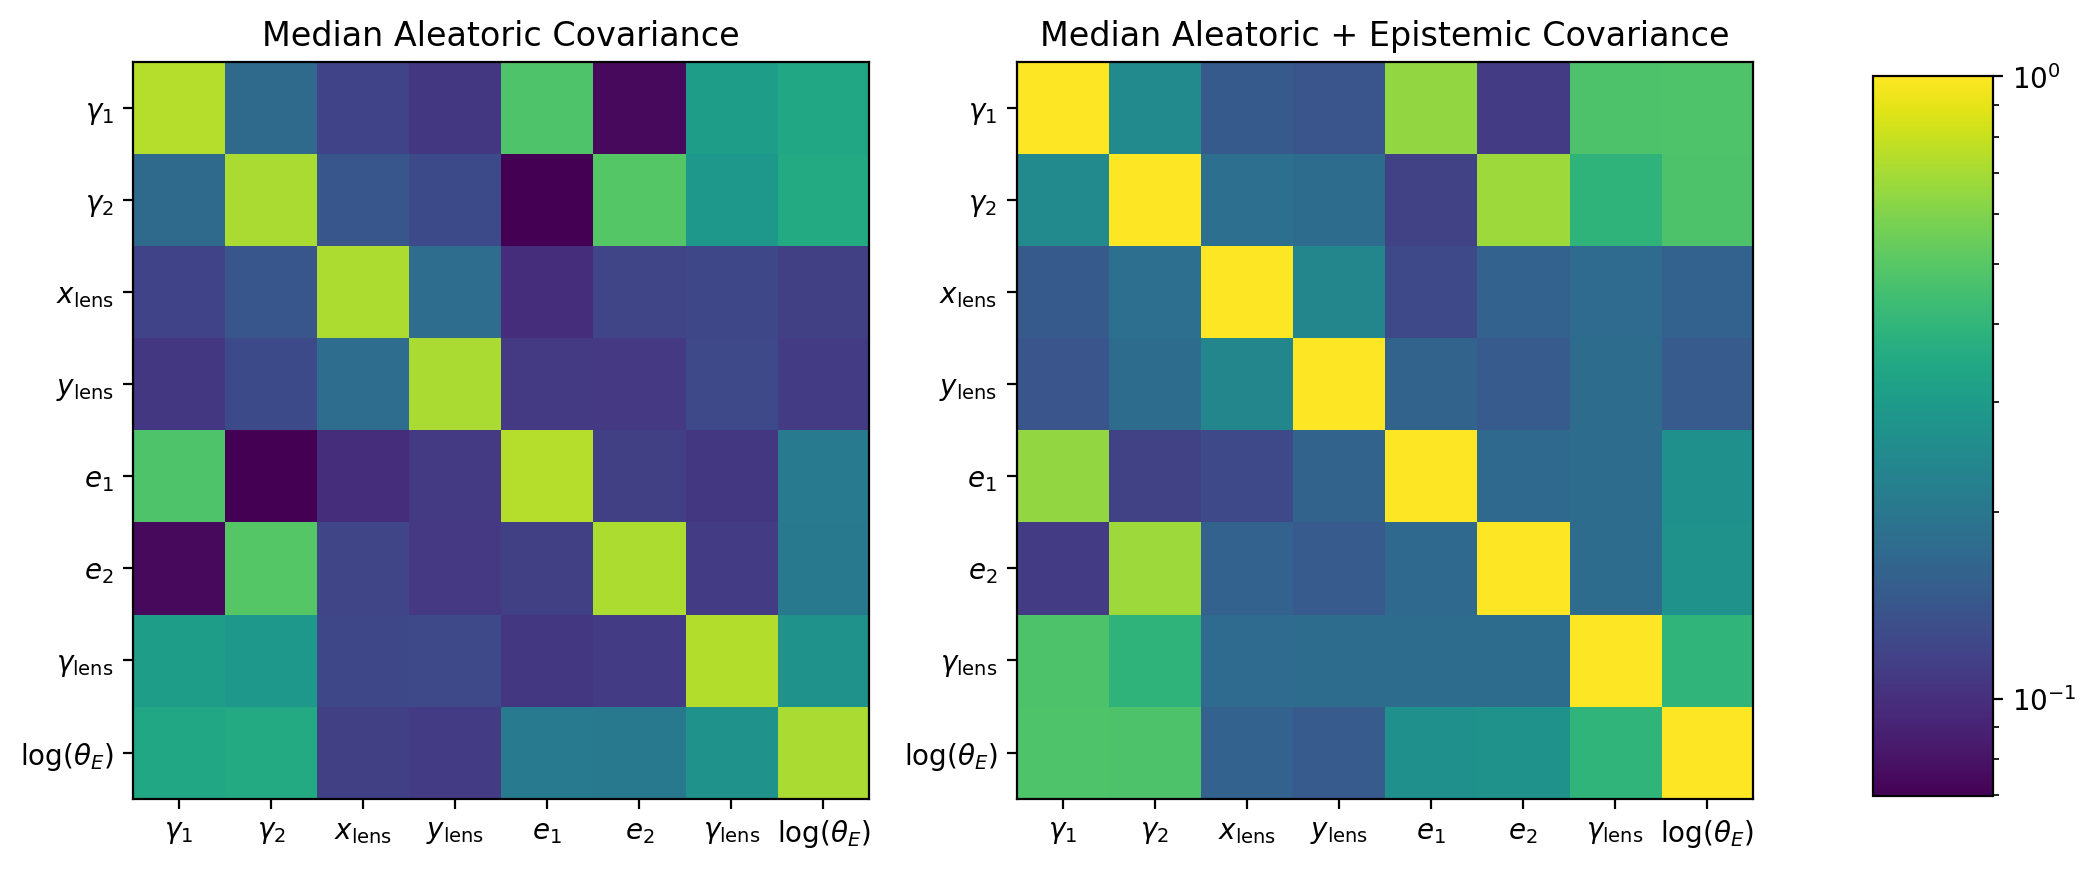

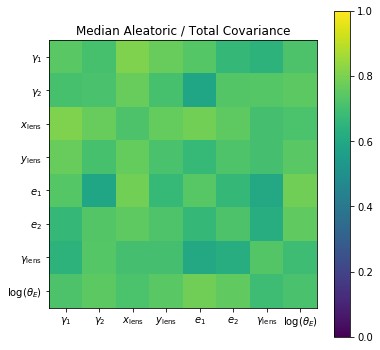

In [48]:
bnn_infer.comp_al_ep_unc()

## GMM No Regularization

In [6]:
config_path = root_path + 'configs/nn3_zr.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)
bnn_infer = bnn_inference.InferenceClass(cfg)
save_path_nn3_zr = root_path + 'validation_results/nn3_zr_samps/'
bnn_infer.gen_samples(num_samples,save_path_nn3_zr)

Is model built: True
Loaded weights /home/swagnercarena/ovejero/models/nn3_zr.h5
Loading samples from /home/swagnercarena/ovejero/validation_results/nn3_zr_samps/


In [7]:
bnn_infer.report_stats()

Parameter, RMSE, Median Abs Error, Median Std
external_shear_g1 0.06599681691312852 0.010249583775197638 0.01588698210852965
external_shear_g2 0.03352837420016323 0.011069675126139647 0.01684237525437833
lens_mass_center_x 0.017036505791910784 0.006600894714898563 0.008640986498520246
lens_mass_center_y 0.022857362440228145 0.006867304687399229 0.009638541229974162
lens_mass_e1 0.04865604515528482 0.01803926105342664 0.027641727184264858
lens_mass_e2 0.046979670960917194 0.017771880677362455 0.02956991464760541
lens_mass_gamma 0.07093624136263907 0.035792081620847904 0.05460445726803516
lens_mass_theta_E_log 0.032071931970550485 0.006063646404918266 0.009804402057354947


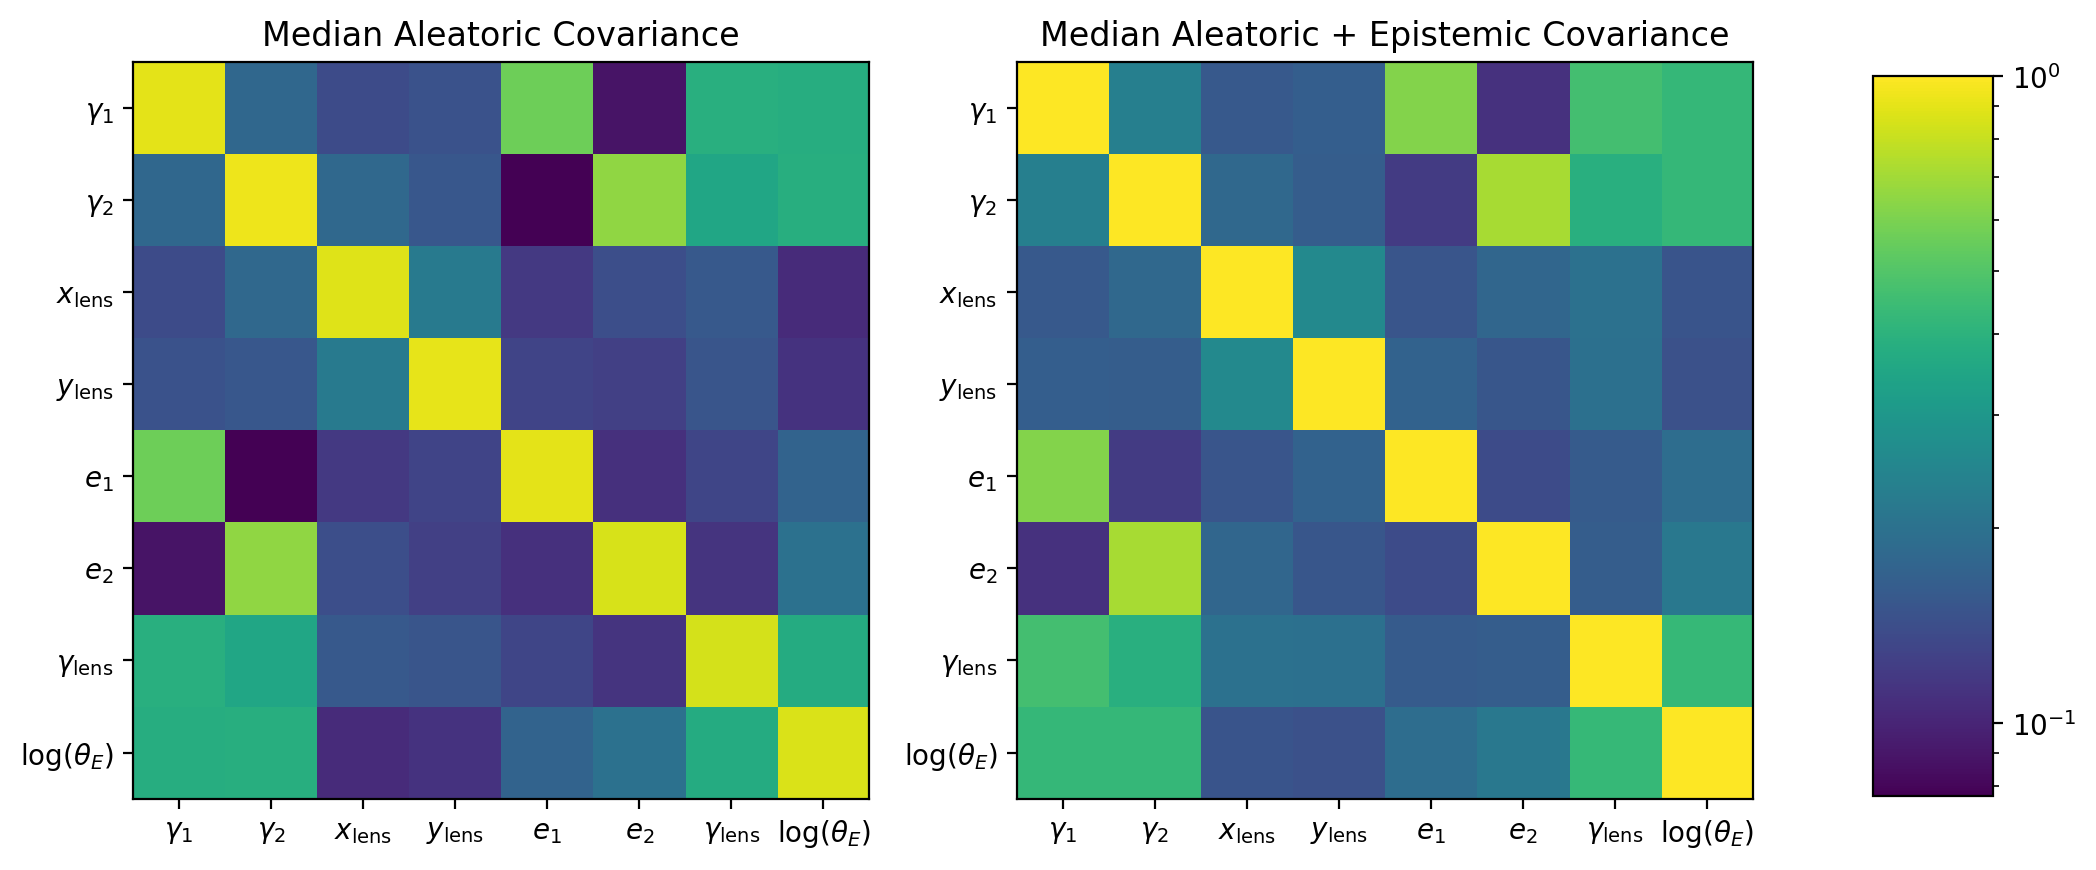

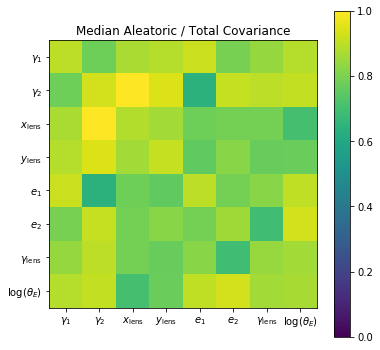

In [51]:
bnn_infer.comp_al_ep_unc()

## GMM 0.1% Dropout

In [8]:
config_path = root_path + 'configs/nn3_slr.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)
bnn_infer = bnn_inference.InferenceClass(cfg)
save_path_nn3_slr = root_path + 'validation_results/nn3_slr_samps/'
bnn_infer.gen_samples(num_samples,save_path_nn3_slr)

Is model built: True
Loaded weights /home/swagnercarena/ovejero/models/nn3_slr.h5
Loading samples from /home/swagnercarena/ovejero/validation_results/nn3_slr_samps/


In [9]:
bnn_infer.report_stats()

Parameter, RMSE, Median Abs Error, Median Std
external_shear_g1 0.05908780090519915 0.009077936821658372 0.012642498051207287
external_shear_g2 0.028186528545507114 0.010120998539978943 0.01302806053409581
lens_mass_center_x 0.014598400763798536 0.004962460129815233 0.007303601643996606
lens_mass_center_y 0.01697906246889523 0.00555599494468299 0.007454047348447278
lens_mass_e1 0.03863507484280858 0.015012583936011098 0.021178982800852834
lens_mass_e2 0.03874686109745828 0.01713452725338635 0.022027664706838375
lens_mass_gamma 0.060849466762664846 0.028026753123854498 0.04380683147839355
lens_mass_theta_E_log 0.030770050946392943 0.005607662022687948 0.007788986608731901


## GMM Comparison

Is model built: True
Loaded weights /home/swagnercarena/ovejero/models/nn3_zr.h5
Loading samples from /home/swagnercarena/ovejero/validation_results/nn3_zr_samps/
Is model built: True
Loaded weights /home/swagnercarena/ovejero/models/nn3_slr.h5
Loading samples from /home/swagnercarena/ovejero/validation_results/nn3_slr_samps/
Is model built: True
Loaded weights /home/swagnercarena/ovejero/models/nn3_lr.h5
Loading samples from /home/swagnercarena/ovejero/validation_results/nn3_lr_samps/
Is model built: True
Loaded weights /home/swagnercarena/ovejero/models/nn3.h5
Loading samples from /home/swagnercarena/ovejero/validation_results/nn3_samps/


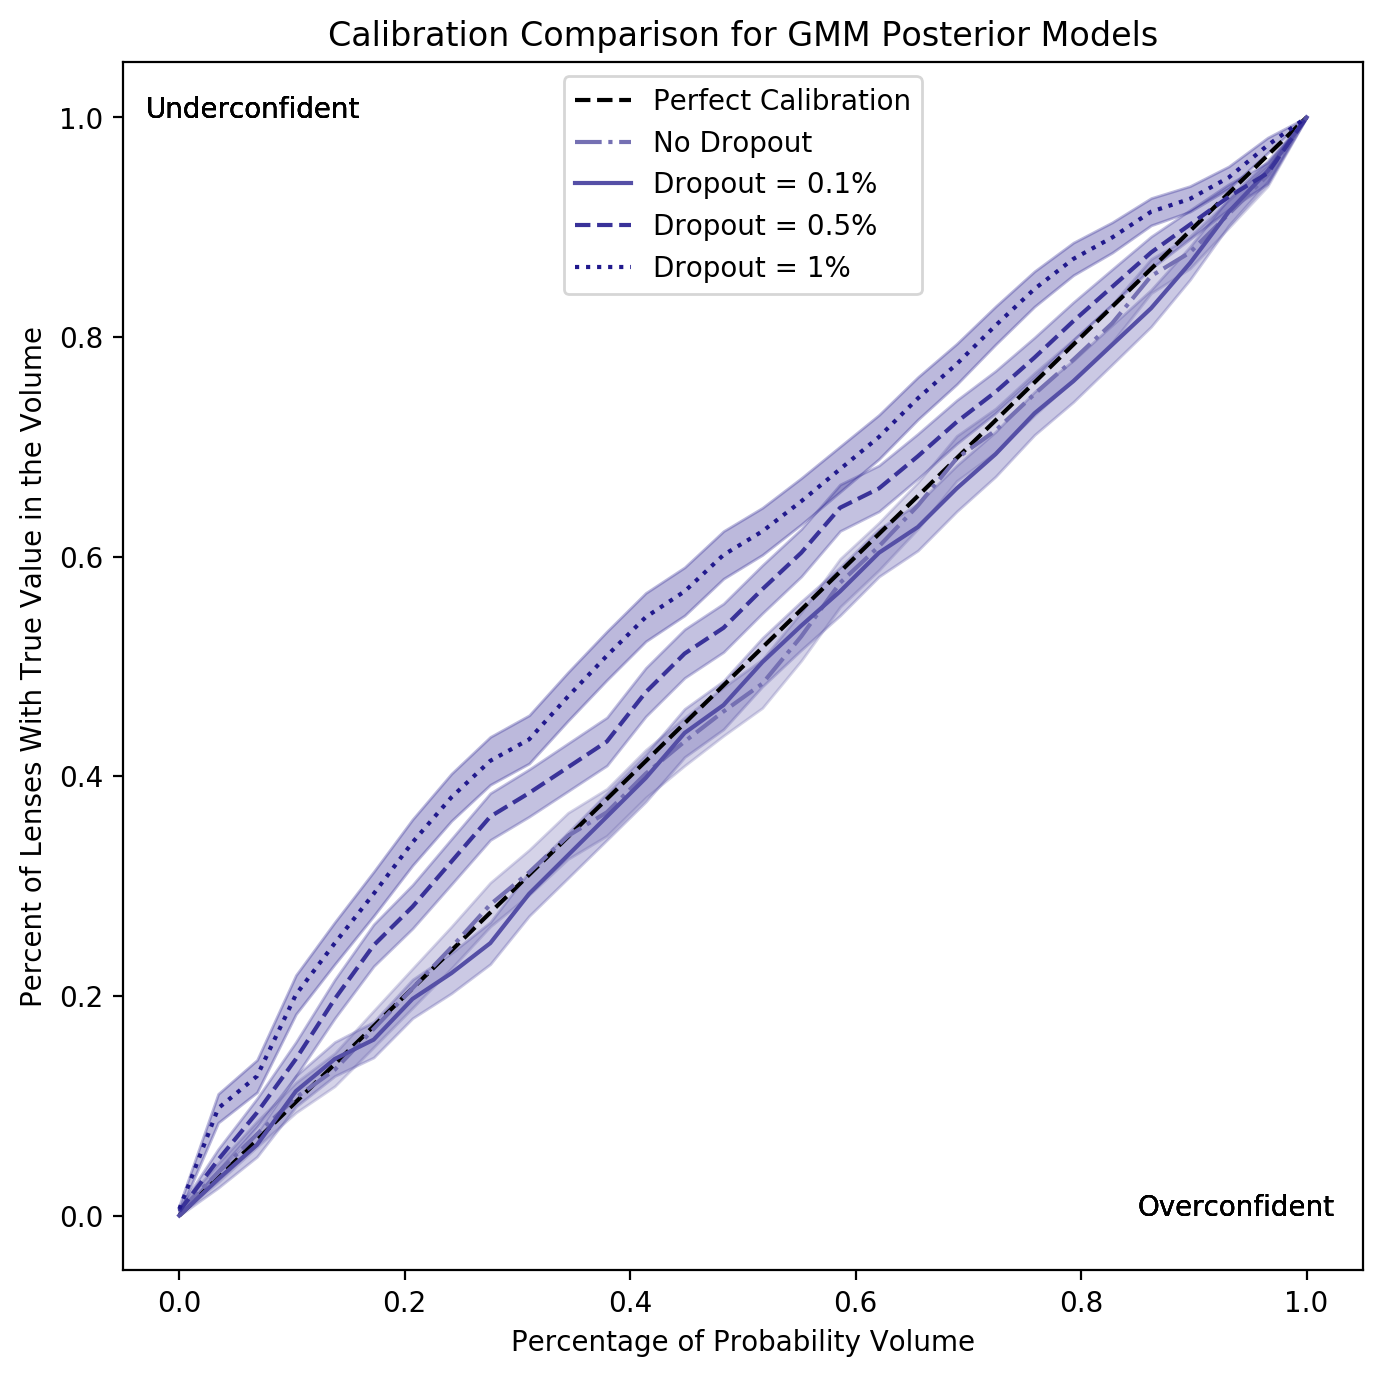

In [53]:
# color_map = ['#000000','#1b9e77','#d95f02','#7570b3','#e7298a']
color_map = ['#000000','#7570b3','#554fa6','#393299','#21198d']
ls_list =['-.','-','--',':']

# NN3_ZR
config_path = root_path + 'configs/nn3_zr.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)
bnn_infer = bnn_inference.InferenceClass(cfg)
bnn_infer.gen_samples(num_samples,save_path_nn3_zr)
n_perc_points = 30
fig = bnn_infer.plot_calibration(color_map=color_map,n_perc_points=n_perc_points,show_plot=False,ls=ls_list[0])

# NN3_LR
config_path = root_path + 'configs/nn3_slr.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)
bnn_infer = bnn_inference.InferenceClass(cfg)
bnn_infer.gen_samples(num_samples,save_path_nn3_slr)
n_perc_points = 30
fig = bnn_infer.plot_calibration(color_map=color_map[1:],n_perc_points=n_perc_points,figure=fig,show_plot=False,
                                 ls=ls_list[1])

# NN3
config_path = root_path + 'configs/nn3_lr.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)
bnn_infer = bnn_inference.InferenceClass(cfg)
bnn_infer.gen_samples(num_samples,save_path_nn3_lr)
fig = bnn_infer.plot_calibration(color_map=color_map[2:],n_perc_points=n_perc_points,figure=fig,show_plot=False,
                                ls=ls_list[2])

# NN3_HR
config_path = root_path + 'configs/nn3.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)
bnn_infer = bnn_inference.InferenceClass(cfg)
bnn_infer.gen_samples(num_samples,save_path_nn3)
fig = bnn_infer.plot_calibration(color_map=color_map[3:],n_perc_points=n_perc_points,figure=fig,show_plot=False,
                                legend=['Perfect Calibration',r'No Dropout',r'Dropout = 0.1%',r'Dropout = 0.5%',
                                       r'Dropout = 1%'],
                                 title='Calibration Comparison for GMM Posterior Models',ls=ls_list[3])

save_cal_path = 'figures/gmm_cal.pdf'
plt.savefig(save_cal_path)
plt.show()

## Combined Plot

Is model built: True
Loaded weights /home/swagnercarena/ovejero/models/nn1_hr.h5
Loading samples from /home/swagnercarena/ovejero/validation_results/nn1_hr_samps/
Is model built: True
Loaded weights /home/swagnercarena/ovejero/models/nn2_slr.h5
Loading samples from /home/swagnercarena/ovejero/validation_results/nn2_slr_samps/
Is model built: True
Loaded weights /home/swagnercarena/ovejero/models/nn3_slr.h5
Loading samples from /home/swagnercarena/ovejero/validation_results/nn3_slr_samps/


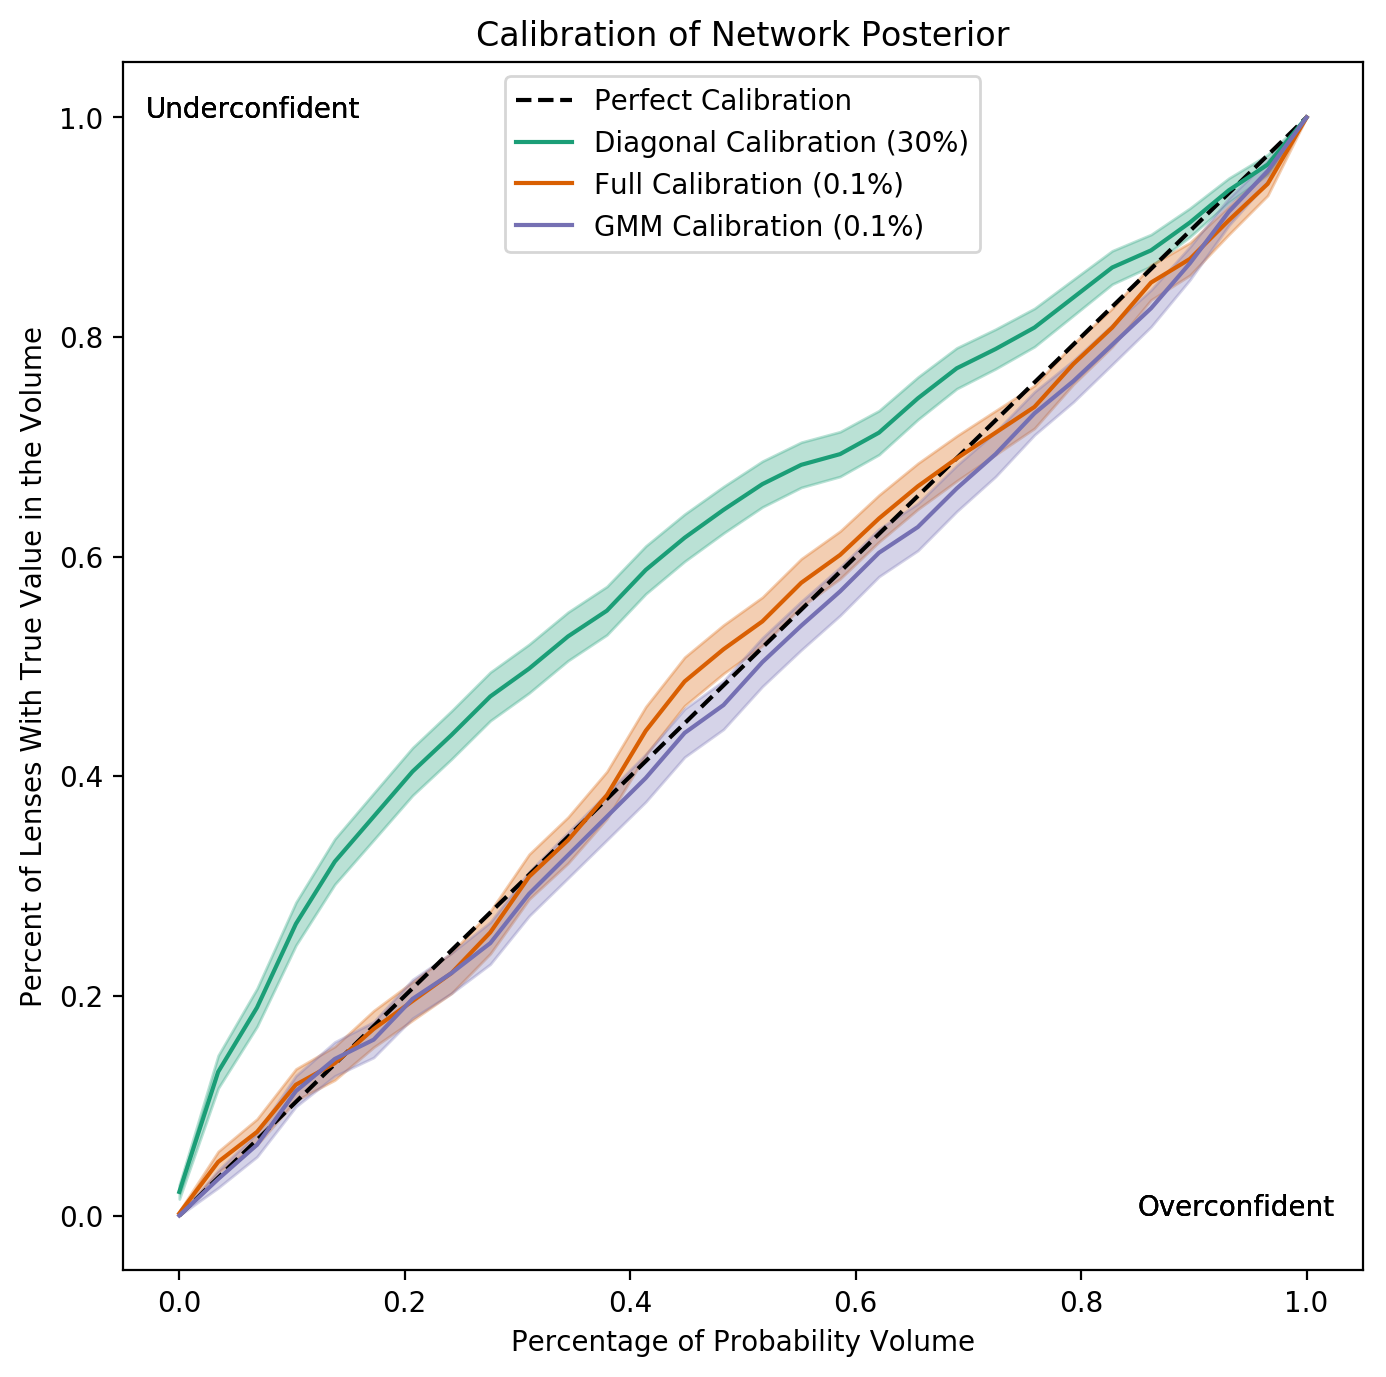

In [54]:
# First specify the config path
config_path = root_path + 'configs/nn1_hr.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)
bnn_infer = bnn_inference.InferenceClass(cfg)
num_samples = 1000
bnn_infer.gen_samples(num_samples,save_path_nn1_hr)

color_map = ['#000000','#1b9e77','#d95f02','#7570b3','#e7298a']
n_perc_points = 30
fig = bnn_infer.plot_calibration(color_map=color_map,n_perc_points=n_perc_points,show_plot=False)

# NN2
config_path = root_path + 'configs/nn2_slr.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)
bnn_infer = bnn_inference.InferenceClass(cfg)
bnn_infer.gen_samples(num_samples,save_path_nn2_slr)
fig = bnn_infer.plot_calibration(color_map=color_map[1:],n_perc_points=n_perc_points,figure=fig,show_plot=False)

# NN3
config_path = root_path + 'configs/nn3_slr.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)
bnn_infer = bnn_inference.InferenceClass(cfg)
bnn_infer.gen_samples(num_samples,save_path_nn3_slr)
fig = bnn_infer.plot_calibration(color_map=color_map[2:],n_perc_points=n_perc_points,figure=fig,show_plot=False,
                                legend=['Perfect Calibration',r'Diagonal Calibration (30%)',r'Full Calibration (0.1%)',
                                       r'GMM Calibration (0.1%)'])

save_cal_path = 'figures/all_cal.pdf'
plt.savefig(save_cal_path)
plt.show()